# Pipeline End-to-End Clustering Machine Learning

## 1. Pendahuluan

Notebook ini menyajikan pipeline end-to-end untuk analisis clustering menggunakan dataset transaksi retail. Kita akan melakukan langkah-langkah berikut:

1. Pengumpulan dan pembersihan data menggunakan Pandas
2. Feature Selection (Constant, Quasi-Constant, Duplicates, Correlation, dll)
3. Feature Engineering (Transformasi Data, Standardisasi, Normalisasi, dll)
4. Implementasi dan evaluasi beberapa model clustering:
   - KMeans
   - AgglomerativeClustering
   - DBSCAN
   - GaussianMixture
   - SpectralClustering
5. Evaluasi dengan berbagai metrik:
   - Silhouette Score
   - Davies-Bouldin Index
   - Calinski-Harabasz Score
6. Visualisasi hasil clustering:
   - Silhouette Plot
   - Dendrogram
   - Cluster Scatter Plot

Mari kita mulai!

## 2. Import Library yang Dibutuhkan

In [1]:
# Library dasar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest, chi2, f_classif

# Library untuk model clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

# Library untuk evaluasi
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage

# Mengabaikan warning yang tidak perlu
warnings.filterwarnings('ignore')

# Setting untuk tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 3. Pengumpulan dan Pembersihan Data

### 3.1 Membaca Data

In [4]:
# Membaca dataset
df = pd.read_csv('UTSClustering.csv', encoding='latin-1')

# Melihat beberapa baris pertama dari dataset
print("Informasi awal dataset:")
display(df.head())

# Melihat informasi dataset
print("\nInformasi dataset:")
display(df.info())

# Rangkuman statistik
print("\nRangkuman statistik:")
display(df.describe())

# Mengecek jumlah nilai yang hilang
print("\nNilai yang hilang pada setiap kolom:")
display(df.isnull().sum())

Informasi awal dataset:


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


Rangkuman statistik:


Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


Nilai yang hilang pada setiap kolom:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 3.2 Pembersihan Data

In [5]:
# Menghapus baris dengan nilai yang hilang
df_clean = df.dropna()
print(f"Jumlah baris setelah menghapus nilai yang hilang: {df_clean.shape[0]} (dari {df.shape[0]} baris awal)")

# Mengecek duplikasi data
duplicates = df_clean.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicates}")

# Menghapus duplikasi jika ada
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Jumlah baris setelah menghapus duplikat: {df_clean.shape[0]}")

# Mengkonversi kolom tanggal ke format datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Membuat fitur baru berdasarkan tanggal
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# Menghitung total nilai transaksi
df_clean['TotalValue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Cek nilai negatif atau nol pada kolom penting
print("\nJumlah nilai Quantity <= 0:", (df_clean['Quantity'] <= 0).sum())
print("Jumlah nilai UnitPrice <= 0:", (df_clean['UnitPrice'] <= 0).sum())

# Hapus transaksi dengan Quantity atau UnitPrice negatif/nol (jika diperlukan)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"Jumlah baris setelah menghapus nilai negatif/nol: {df_clean.shape[0]}")

Jumlah baris setelah menghapus nilai yang hilang: 406829 (dari 541909 baris awal)
Jumlah baris duplikat: 5225
Jumlah baris setelah menghapus duplikat: 401604

Jumlah nilai Quantity <= 0: 8872
Jumlah nilai UnitPrice <= 0: 40
Jumlah baris setelah menghapus nilai negatif/nol: 392692


### 3.3 Exploratory Data Analysis (EDA)

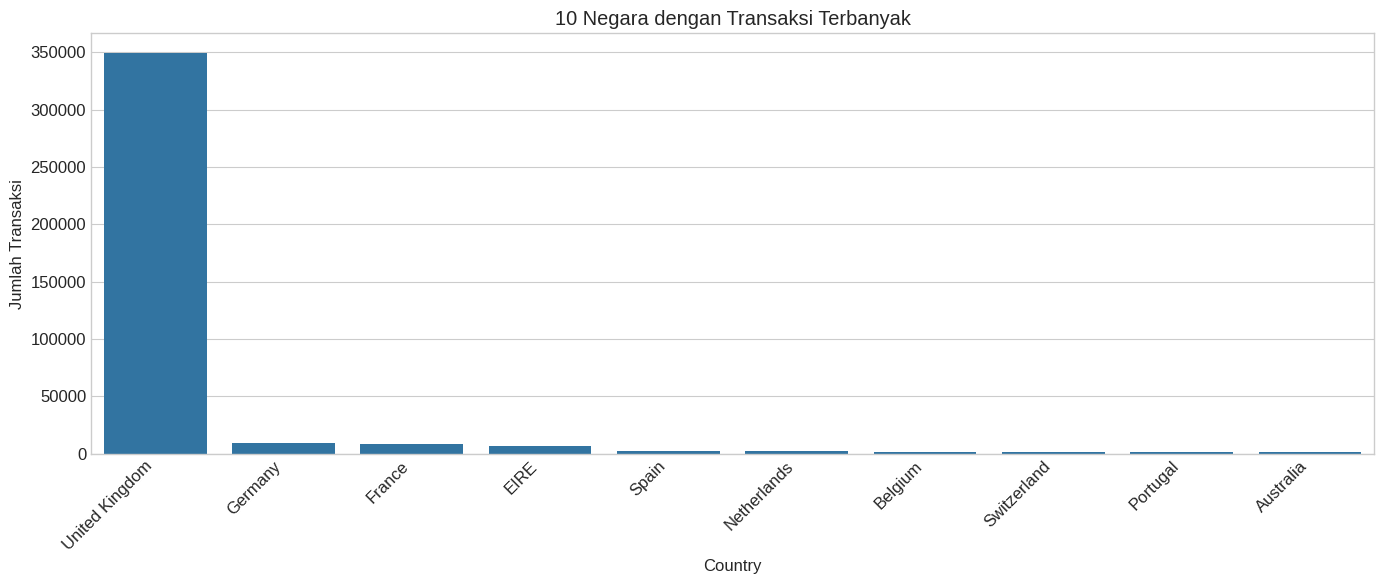

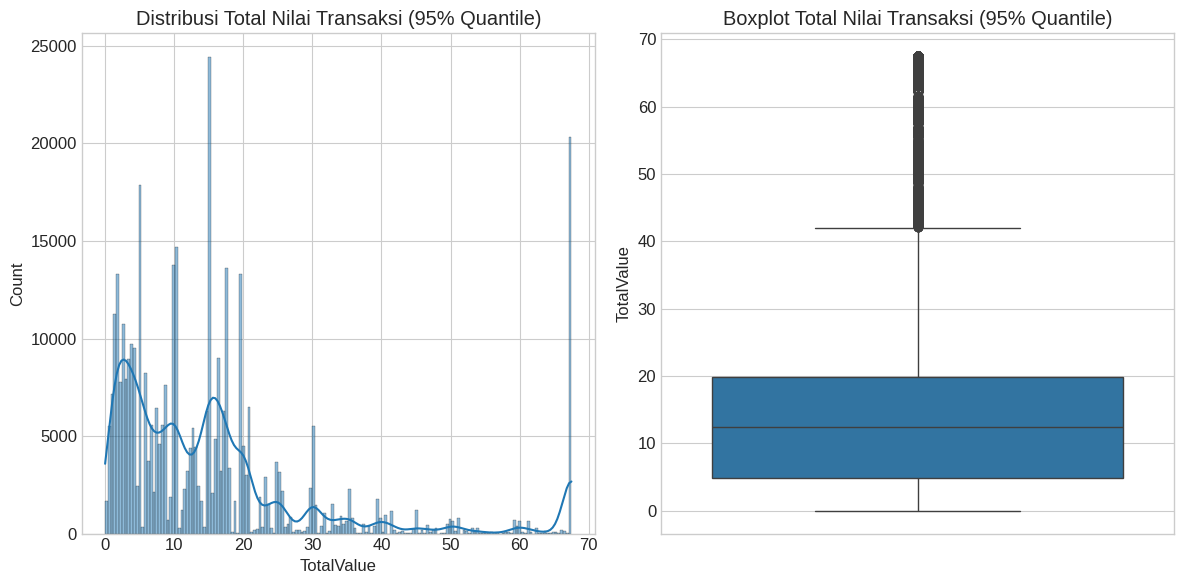

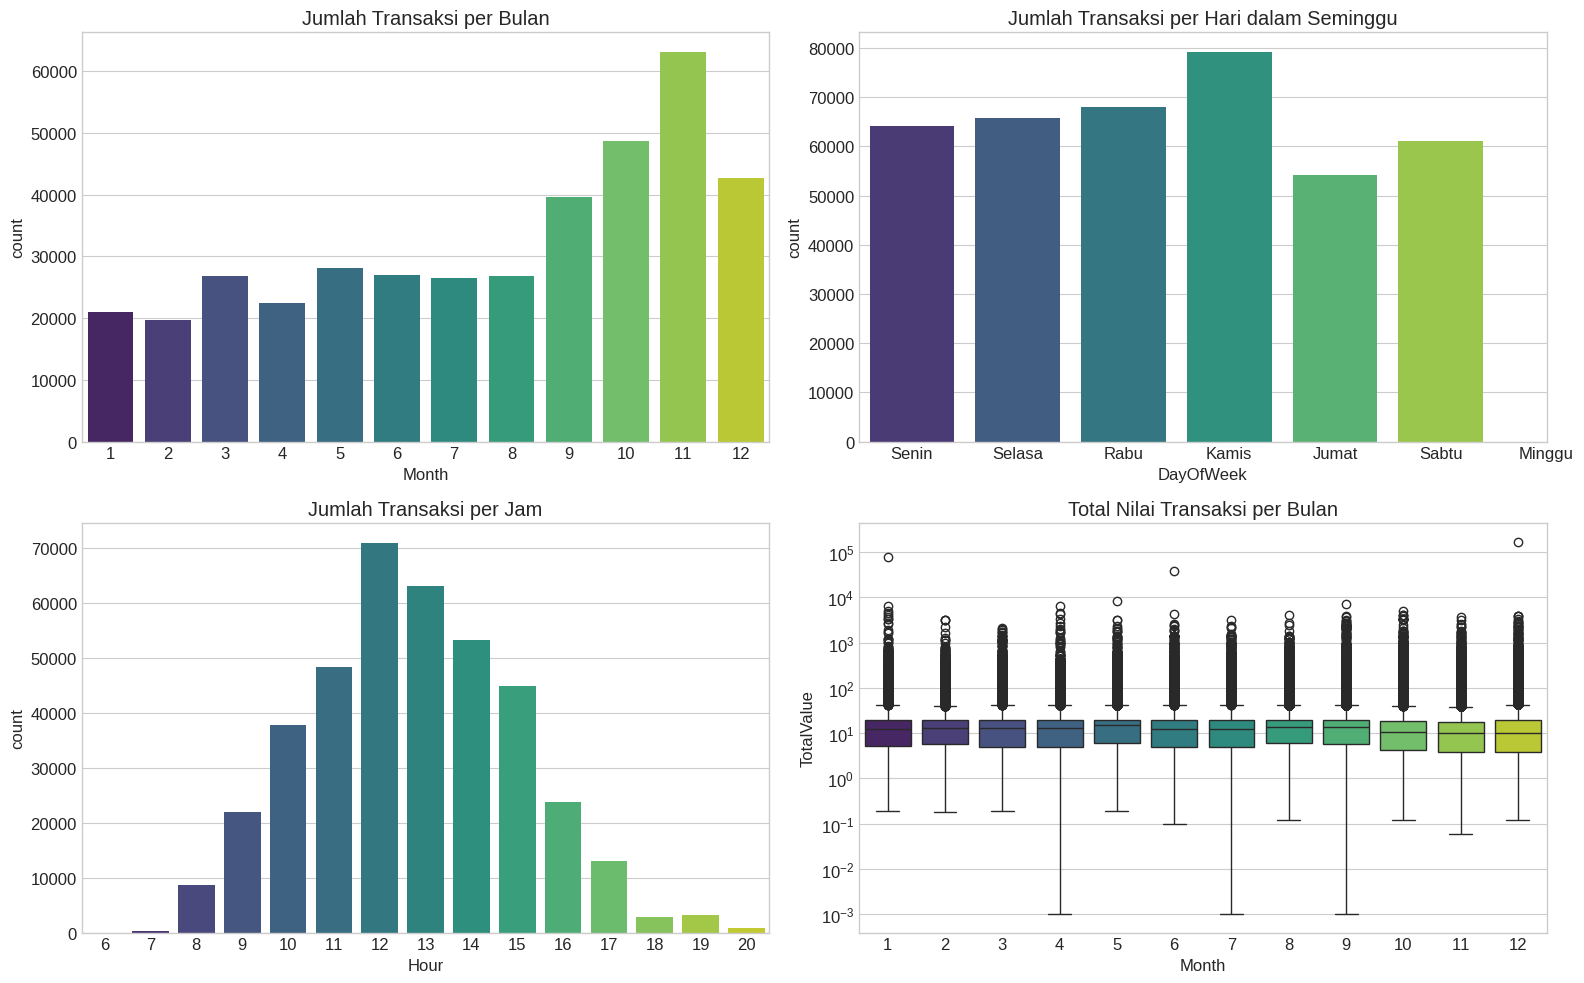

In [7]:
# Melihat distribusi dari Country
plt.figure(figsize=(14, 6))
country_counts = df_clean['Country'].value_counts().sort_values(ascending=False)
sns.barplot(x=country_counts.index[:10], y=country_counts.values[:10])
plt.title('10 Negara dengan Transaksi Terbanyak')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Transaksi')
plt.tight_layout()
plt.show()

# Distribusi nilai transaksi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['TotalValue'].clip(upper=df_clean['TotalValue'].quantile(0.95)), kde=True)
plt.title('Distribusi Total Nilai Transaksi (95% Quantile)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['TotalValue'].clip(upper=df_clean['TotalValue'].quantile(0.95)))
plt.title('Boxplot Total Nilai Transaksi (95% Quantile)')
plt.tight_layout()
plt.show()

# Distribusi waktu transaksi
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='Month', data=df_clean, palette='viridis')
plt.title('Jumlah Transaksi per Bulan')

plt.subplot(2, 2, 2)
sns.countplot(x='DayOfWeek', data=df_clean, palette='viridis')
plt.title('Jumlah Transaksi per Hari dalam Seminggu')
plt.xticks(ticks=range(7), labels=['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])

plt.subplot(2, 2, 3)
sns.countplot(x='Hour', data=df_clean, palette='viridis')
plt.title('Jumlah Transaksi per Jam')

plt.subplot(2, 2, 4)
sns.boxplot(x='Month', y='TotalValue', data=df_clean, palette='viridis')
plt.title('Total Nilai Transaksi per Bulan')
plt.yscale('log')

plt.tight_layout()
plt.show()

## 4. Agregasi Data untuk Clustering
Karena dataset merupakan data transaksi, kita perlu mengelompokkannya berdasarkan CustomerID untuk melakukan clustering pelanggan.

In [8]:
# Menghapus baris tanpa CustomerID
df_customer = df_clean.dropna(subset=['CustomerID'])
df_customer['CustomerID'] = df_customer['CustomerID'].astype(int)

# Agregasi data berdasarkan CustomerID
customer_features = df_customer.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',                  # Jumlah transaksi
    'Quantity': 'sum',                       # Total kuantitas produk
    'TotalValue': 'sum',                     # Total nilai transaksi
    'UnitPrice': 'mean',                     # Rata-rata harga unit
    'InvoiceDate': lambda x: (datetime.now().date() - x.max().date()).days,  # Recency (hari sejak transaksi terakhir)
    'StockCode': 'nunique',                  # Keberagaman produk
    'Country': lambda x: x.mode().iloc[0]    # Negara paling sering
})

# Mengganti nama kolom agar lebih deskriptif
customer_features.rename(columns={
    'InvoiceNo': 'TransactionCount',
    'InvoiceDate': 'Recency'
}, inplace=True)

# Menghitung nilai rata-rata per transaksi
customer_features['AvgTransactionValue'] = customer_features['TotalValue'] / customer_features['TransactionCount']

# Mengecek hasil agregasi
print("Dataset hasil agregasi berdasarkan CustomerID:")
display(customer_features.head())
print(f"Jumlah pelanggan unik: {customer_features.shape[0]}")

Dataset hasil agregasi berdasarkan CustomerID:


TransactionCount  Quantity  TotalValue  UnitPrice  Recency  \
CustomerID                                                               
12346                      1     74215    77183.60   1.040000     5219   
12347                      7      2458     4310.00   2.644011     4896   
12348                      4      2341     1797.24   5.764839     4969   
12349                      1       631     1757.55   8.289041     4912   
12350                      1       197      334.40   3.841176     5204   

            StockCode         Country  AvgTransactionValue  
CustomerID                                                  
12346               1  United Kingdom         77183.600000  
12347             103         Iceland           615.714286  
12348              22         Finland           449.310000  
12349              73           Italy          1757.550000  
12350              17          Norway           334.400000

Jumlah pelanggan unik: 4338



## 5. Feature Selection

### 5.1 Eliminasi Fitur Konstan dan Quasi-Konstan

In [9]:
# Memilih fitur numerik saja untuk clustering
numeric_features = customer_features.select_dtypes(include=['int64', 'float64']).copy()

# Mengidentifikasi fitur konstan atau quasi-konstan (variasi rendah)
var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(numeric_features)
constant_features = [feature for feature, variance in zip(numeric_features.columns, var_threshold.variances_) if variance <= 0.01]

print(f"Fitur dengan variasi rendah (akan dihapus): {constant_features}")
if constant_features:
    numeric_features = numeric_features.drop(columns=constant_features)

print(f"Jumlah fitur setelah eliminasi quasi-konstan: {numeric_features.shape[1]}")

Fitur dengan variasi rendah (akan dihapus): []
Jumlah fitur setelah eliminasi quasi-konstan: 7


### 5.2 Analisis Korelasi

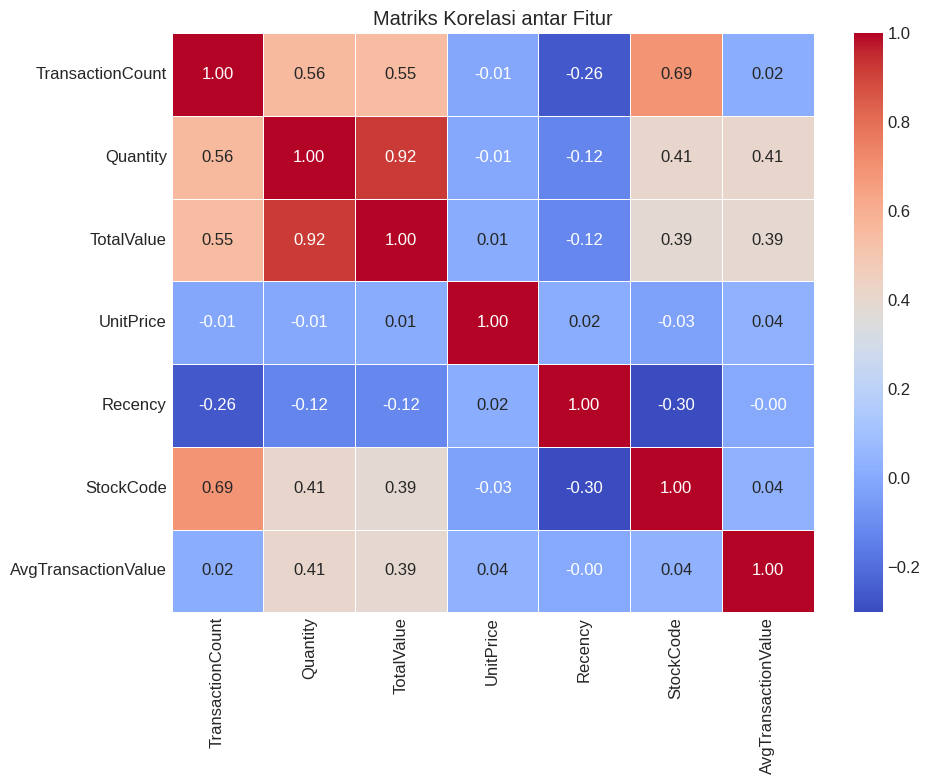

Fitur dengan korelasi tinggi (akan dihapus): {'TotalValue'}
Jumlah fitur setelah eliminasi korelasi tinggi: 6


In [10]:
# Menghitung korelasi antar fitur
corr_matrix = numeric_features.corr()

# Visualisasi korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi antar Fitur')
plt.tight_layout()
plt.show()

# Menghapus fitur dengan korelasi tinggi (threshold 0.9)
high_corr_threshold = 0.9
high_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            colname = corr_matrix.columns[j]
            high_corr_features.add(colname)

print(f"Fitur dengan korelasi tinggi (akan dihapus): {high_corr_features}")
if high_corr_features:
    numeric_features = numeric_features.drop(columns=list(high_corr_features))

print(f"Jumlah fitur setelah eliminasi korelasi tinggi: {numeric_features.shape[1]}")

## 6. Feature Engineering

### 6.1 Deteksi dan Penanganan Outlier

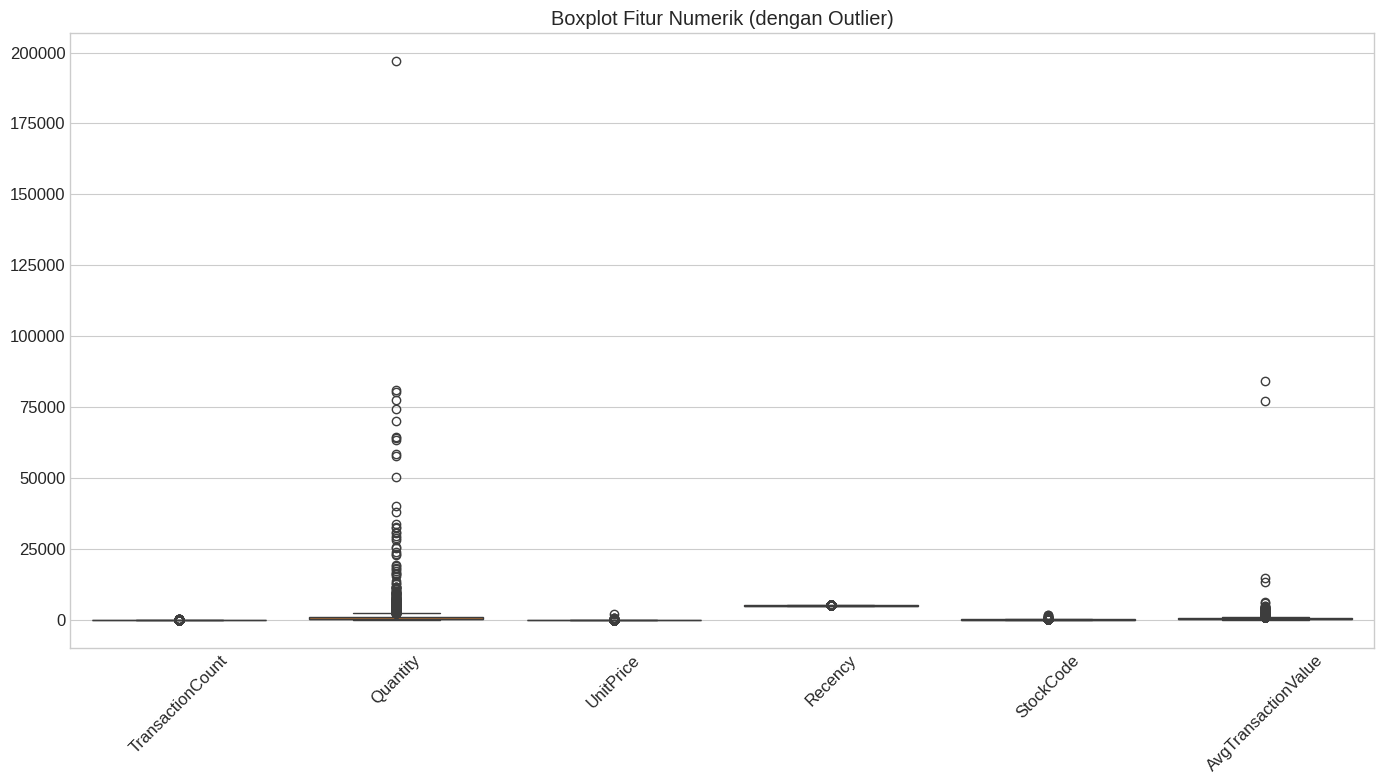

Jumlah outlier terdeteksi: 405


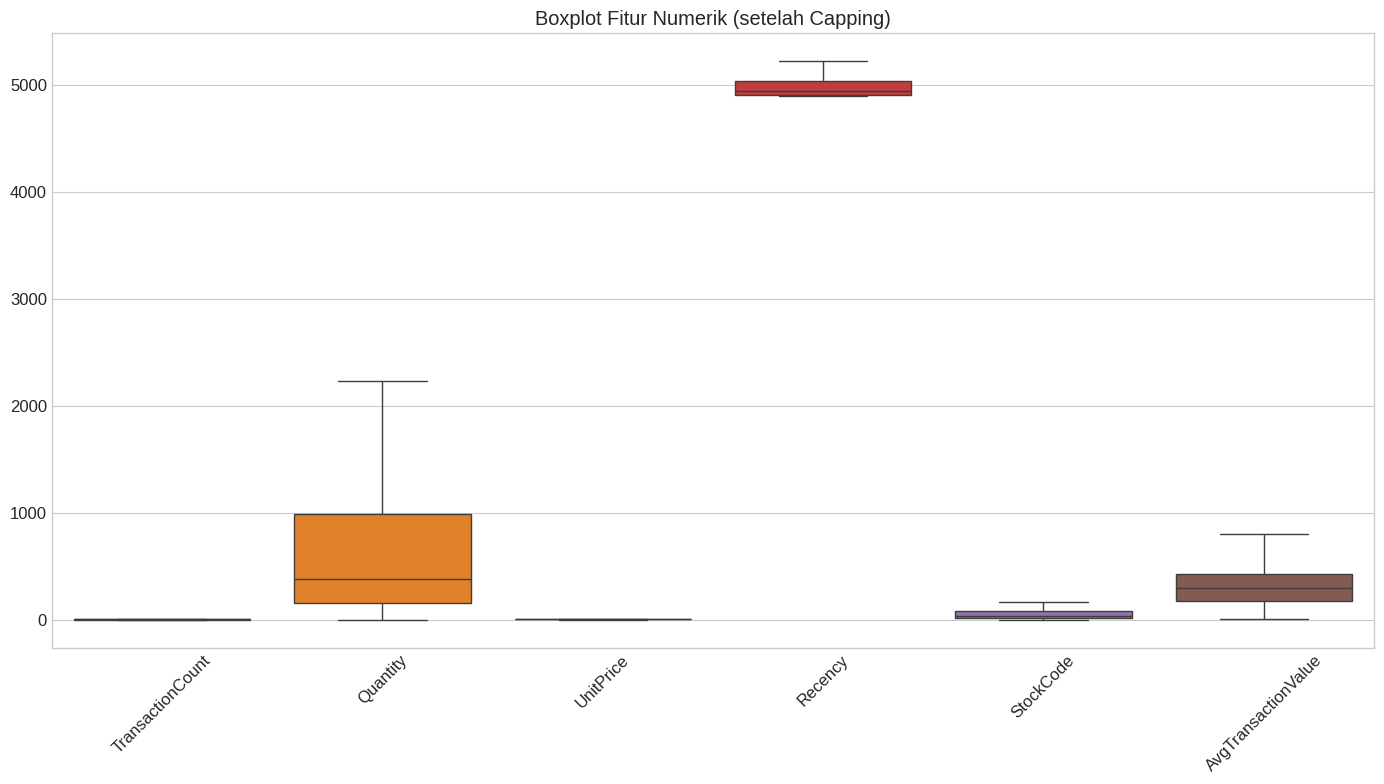

In [11]:
# Visualisasi outlier dengan boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=numeric_features)
plt.title('Boxplot Fitur Numerik (dengan Outlier)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fungsi untuk mendeteksi outlier dengan IQR
def detect_outliers_iqr(df, cols=None, k=1.5):
    if cols is None:
        cols = df.columns

    outlier_indices = []

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Nilai threshold untuk outlier
        outlier_step = IQR * k

        # Identifikasi outlier
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    # Ambil indeks yang muncul lebih dari sekali
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > 1]

    return multiple_outliers

# Import library Counter
from collections import Counter

# Deteksi outlier
outliers = detect_outliers_iqr(numeric_features, k=1.5)
print(f"Jumlah outlier terdeteksi: {len(outliers)}")

# Pendekatan 1: Menghapus outlier
# numeric_features_no_outliers = numeric_features.drop(outliers)
# print(f"Jumlah data setelah menghapus outlier: {numeric_features_no_outliers.shape[0]}")

# Pendekatan 2: Melakukan capping pada outlier
def cap_outliers(df, cols=None, k=1.5):
    if cols is None:
        cols = df.columns

    df_capped = df.copy()

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound,
                             np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col]))

    return df_capped

# Melakukan capping pada outlier
numeric_features_capped = cap_outliers(numeric_features, k=1.5)

# Visualisasi hasil capping
plt.figure(figsize=(14, 8))
sns.boxplot(data=numeric_features_capped)
plt.title('Boxplot Fitur Numerik (setelah Capping)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.2 Normalisasi/Standardisasi Data

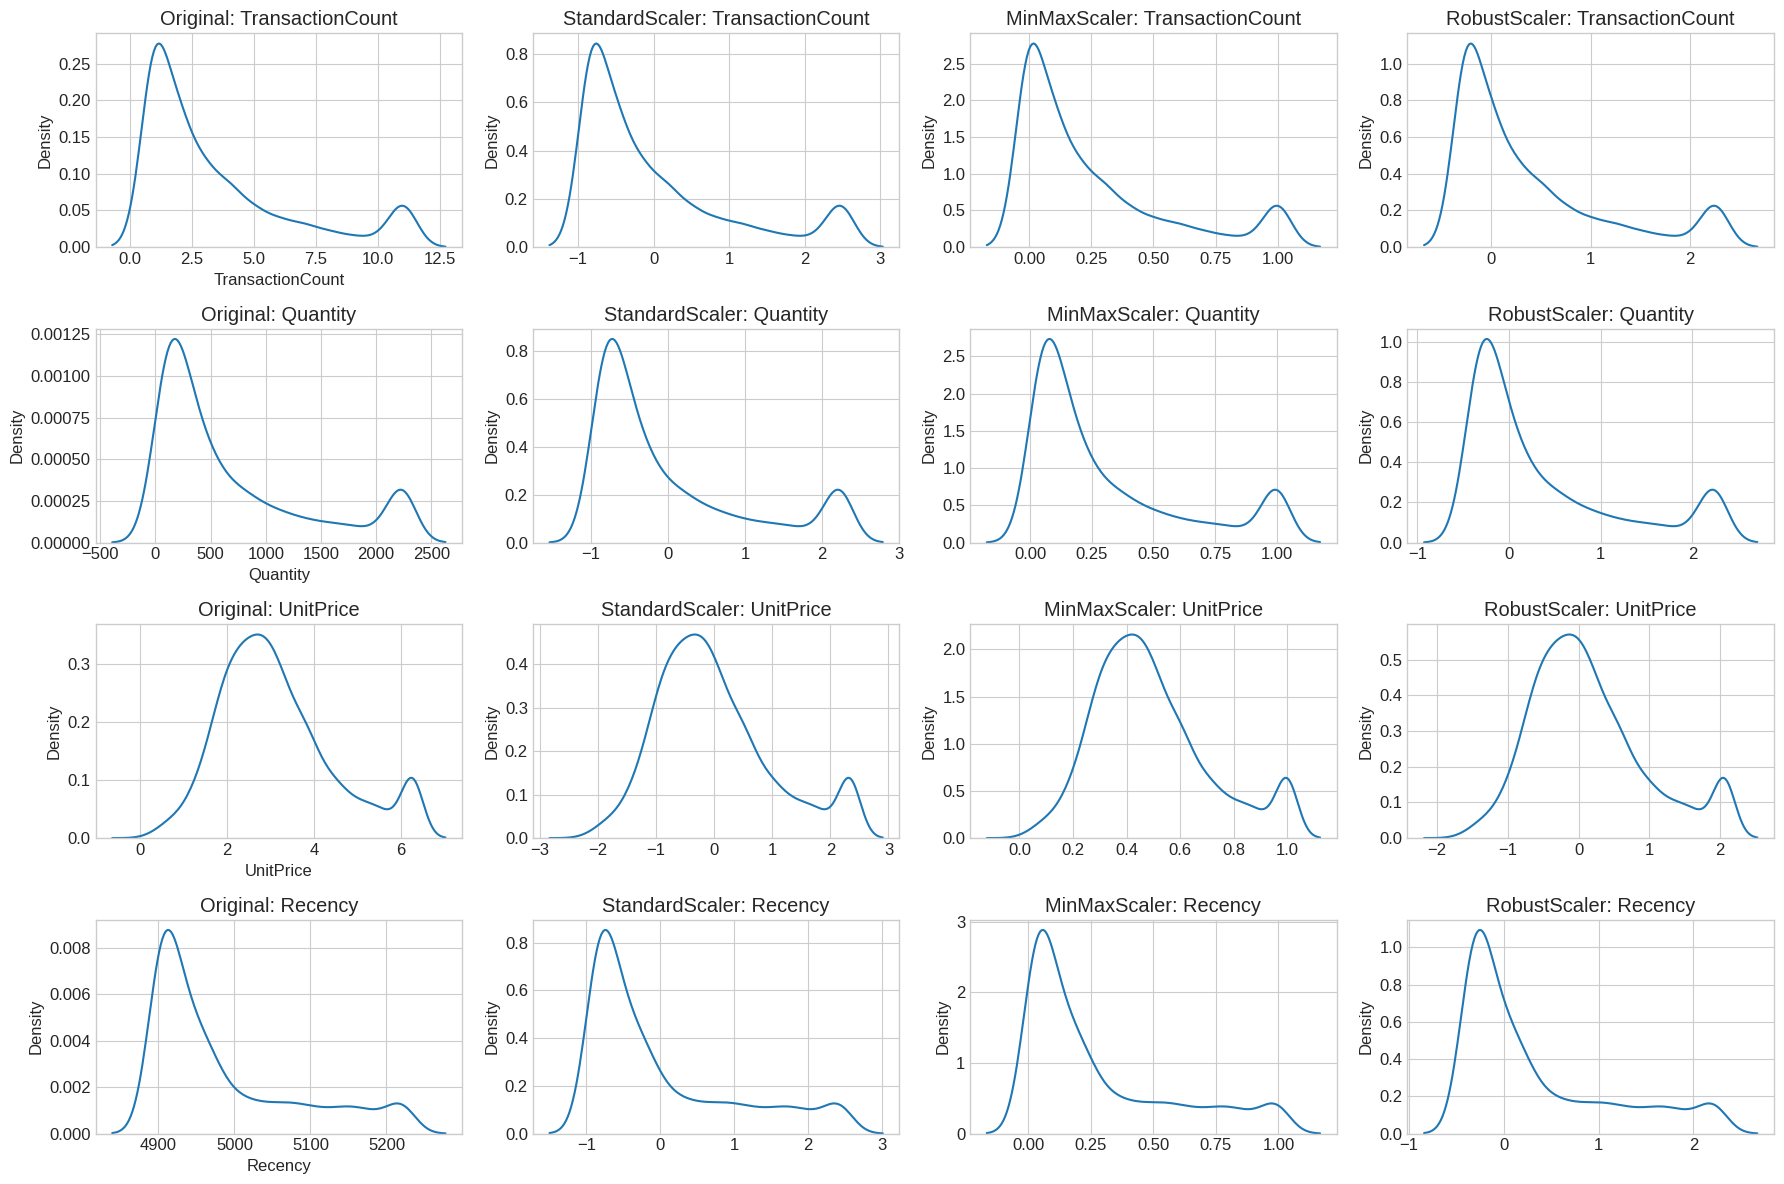

Dataset setelah standardisasi:


TransactionCount  Quantity  UnitPrice   Recency  StockCode  \
CustomerID                                                               
12346              -0.818035  2.229009  -1.582795  2.404625  -1.067334   
12347               1.155805  2.229009  -0.380126 -0.914850   1.001896   
12348               0.168885  2.229009   1.959833 -0.164628  -0.641316   
12349              -0.818035 -0.073331   2.339894 -0.750418   0.393299   
12350              -0.818035 -0.695944   0.517494  2.250470  -0.742749   

            AvgTransactionValue  
CustomerID                       
12346                  2.338001  
12347                  1.406224  
12348                  0.582299  
12349                  2.338001  
12350                  0.013340

In [12]:
# Perbandingan metode scaling
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Bandingkan hasil scaling dengan visualisasi
plt.figure(figsize=(18, 12))
counter = 1

for feature in numeric_features_capped.columns[:4]:  # Pilih 4 fitur pertama untuk visualisasi
    plt.subplot(4, 4, counter)
    sns.kdeplot(numeric_features_capped[feature], label='Original')
    plt.title(f'Original: {feature}')
    counter += 1

    for scaler_name, scaler in scalers.items():
        plt.subplot(4, 4, counter)
        scaled_feature = scaler.fit_transform(numeric_features_capped[[feature]])
        sns.kdeplot(scaled_feature.flatten(), label=scaler_name)
        plt.title(f'{scaler_name}: {feature}')
        counter += 1

plt.tight_layout()
plt.show()

# Pilih StandardScaler untuk standardisasi data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features_capped)
scaled_df = pd.DataFrame(scaled_features, index=numeric_features_capped.index, columns=numeric_features_capped.columns)

print("Dataset setelah standardisasi:")
display(scaled_df.head())

### 6.3 Reduksi Dimensi dengan PCA

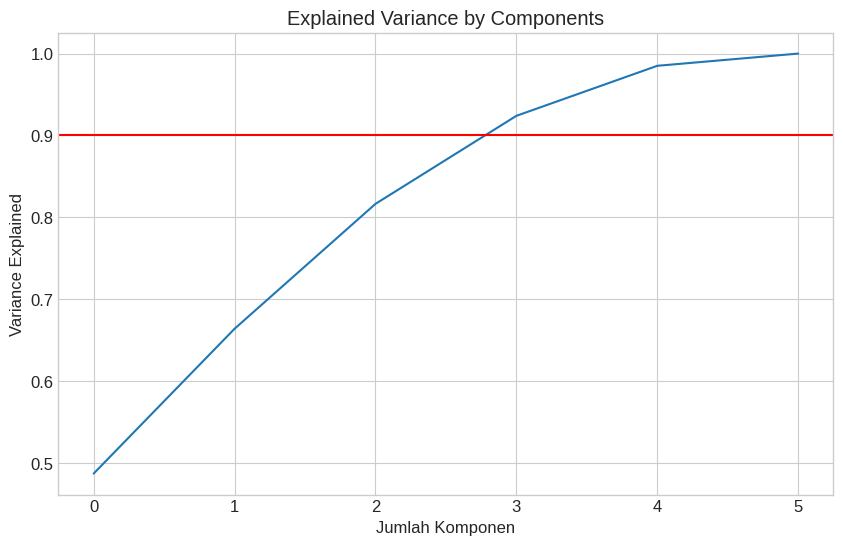

Jumlah komponen PCA yang menyimpan 90% variance: 4
Dataset setelah PCA:


PC1       PC2       PC3       PC4
CustomerID                                        
12346       0.277341  1.083668 -3.768602  1.233736
12347       3.043184  0.388266 -0.619166 -0.160462
12348       0.977580  1.953037  0.638141 -0.235833
12349       0.425111  2.889109 -0.052896 -1.811023
12350      -2.003128  1.058194 -0.630119  1.226930

In [13]:
# Tentukan jumlah komponen PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Plot Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Jumlah Komponen')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Components')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid(True)
plt.show()

# Tentukan jumlah komponen PCA yang menyimpan 90% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Jumlah komponen PCA yang menyimpan 90% variance: {n_components}")

# Terapkan PCA dengan jumlah komponen yang ditentukan
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_result, index=scaled_df.index,
                     columns=[f'PC{i+1}' for i in range(n_components)])

print("Dataset setelah PCA:")
display(pca_df.head())

## 7. Menentukan Jumlah Cluster Optimal



### 7.1 Metode Elbow


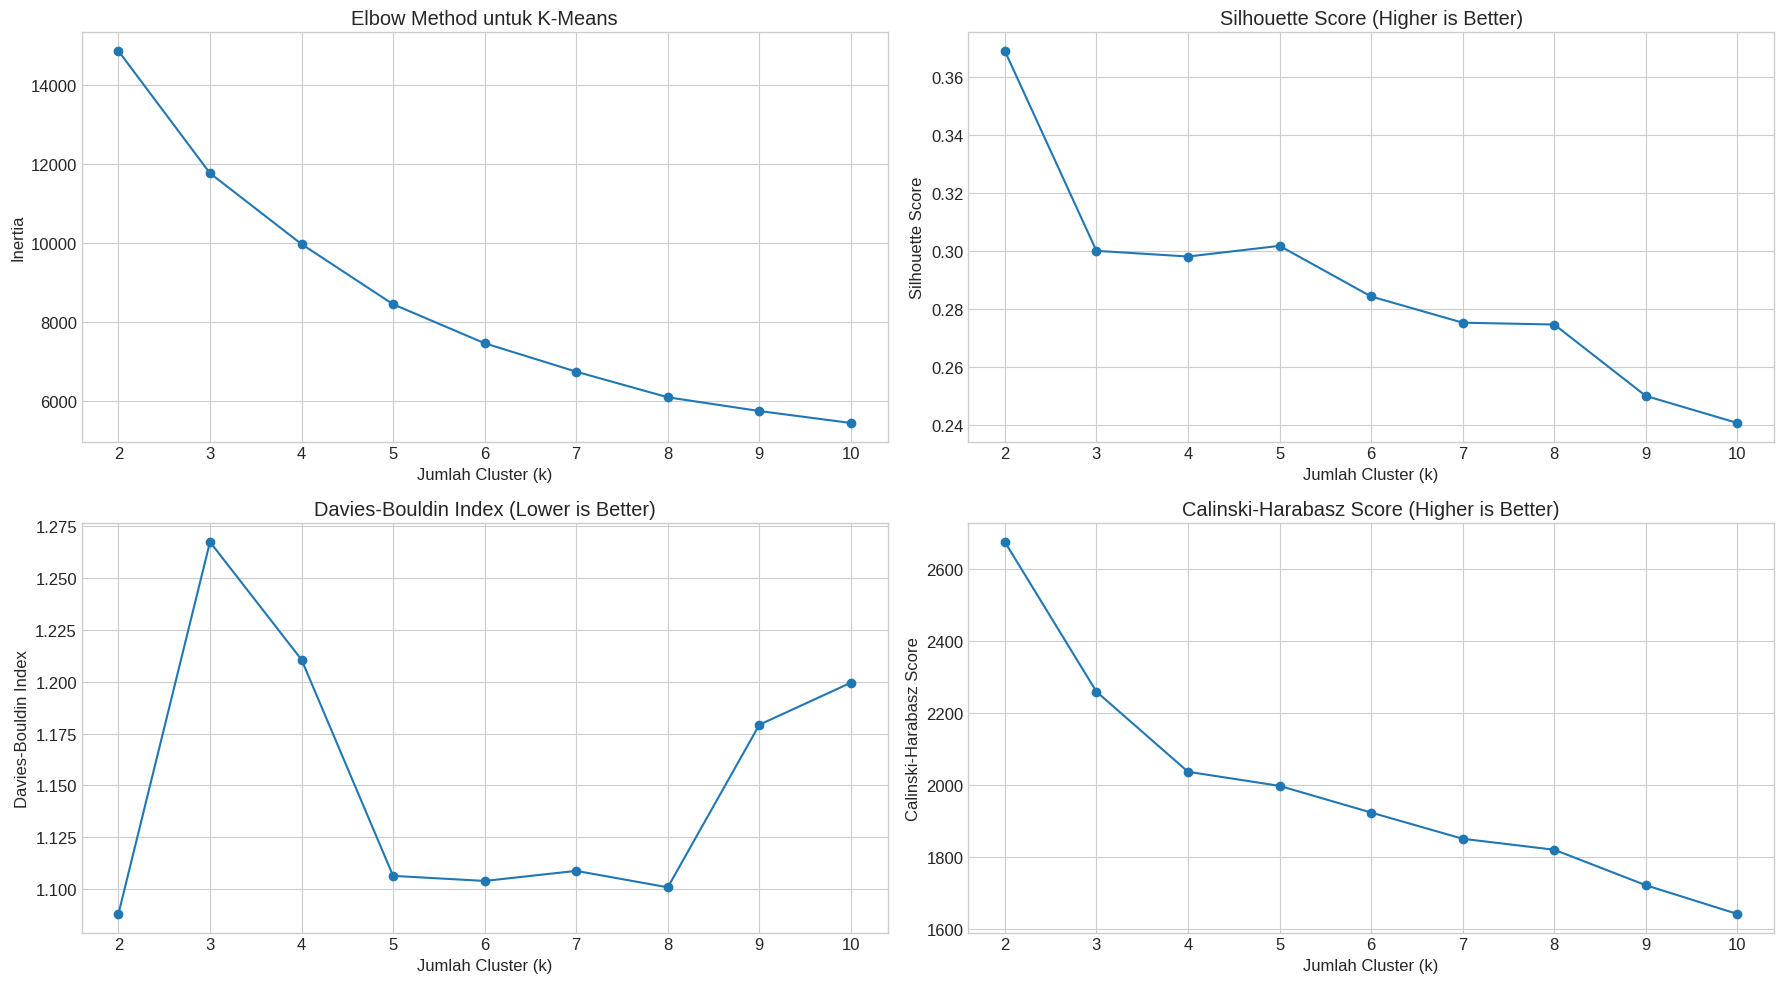

Jumlah cluster optimal berdasarkan Silhouette Score: 2
Jumlah cluster optimal berdasarkan Davies-Bouldin Index: 2
Jumlah cluster optimal berdasarkan Calinski-Harabasz Score: 2


In [14]:
# Metode Elbow untuk K-Means
def plot_elbow_method(data, max_k=10):
    inertia = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        inertia.append(kmeans.inertia_)

        # Hanya hitung metrik evaluasi jika k > 1
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(data, cluster_labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(data, cluster_labels))

    # Plot
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, 'o-')
    plt.xlabel('Jumlah Cluster (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method untuk K-Means')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, 'o-')
    plt.xlabel('Jumlah Cluster (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score (Higher is Better)')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(range(2, max_k + 1), davies_bouldin_scores, 'o-')
    plt.xlabel('Jumlah Cluster (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index (Lower is Better)')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(range(2, max_k + 1), calinski_harabasz_scores, 'o-')
    plt.xlabel('Jumlah Cluster (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Score (Higher is Better)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return inertia, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores

# Plot metode elbow
inertia, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores = plot_elbow_method(pca_df, max_k=10)

# Tampilkan nilai optimal berdasarkan kriteria evaluasi
optimal_k_silhouette = np.argmax(silhouette_scores) + 2
optimal_k_davies = np.argmin(davies_bouldin_scores) + 2
optimal_k_calinski = np.argmax(calinski_harabasz_scores) + 2

print(f"Jumlah cluster optimal berdasarkan Silhouette Score: {optimal_k_silhouette}")
print(f"Jumlah cluster optimal berdasarkan Davies-Bouldin Index: {optimal_k_davies}")
print(f"Jumlah cluster optimal berdasarkan Calinski-Harabasz Score: {optimal_k_calinski}")

### 7.2 Dendrogram untuk Hierarchical Clustering

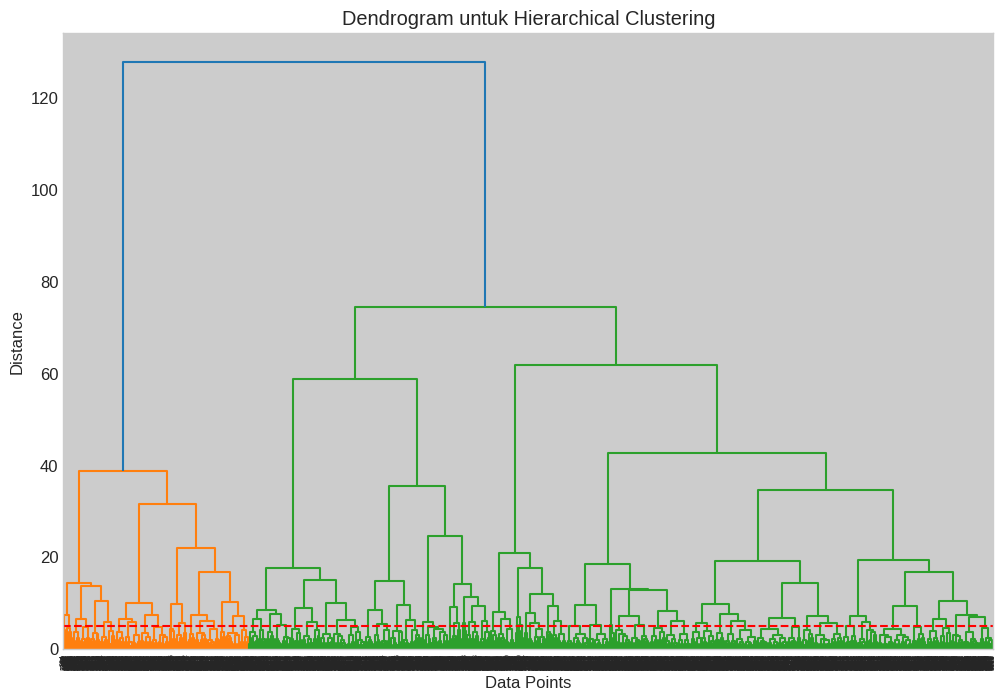

In [15]:
# Membuat dendrogram untuk menentukan jumlah cluster dalam hierarchical clustering
plt.figure(figsize=(12, 8))
mergings = linkage(pca_df, method='ward')
dendrogram(mergings)
plt.title('Dendrogram untuk Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.axhline(y=5, color='r', linestyle='--')  # Contoh threshold
plt.show()

## 8. Implementasi Model Clustering

### 8.1 KMeans Clustering

KMeans - Silhouette Score: 0.3691
KMeans - Davies-Bouldin Index: 1.0878
KMeans - Calinski-Harabasz Score: 2675.8056


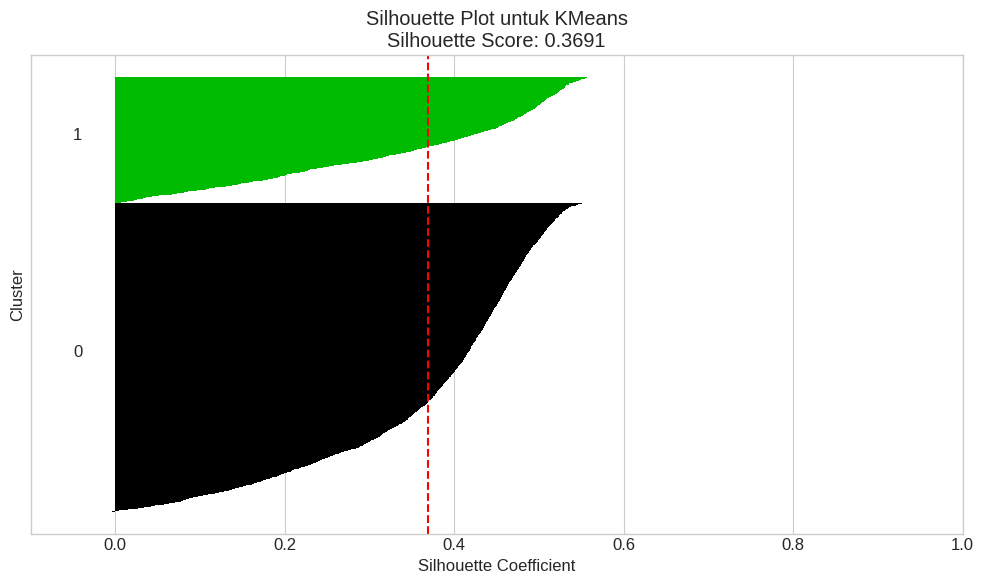

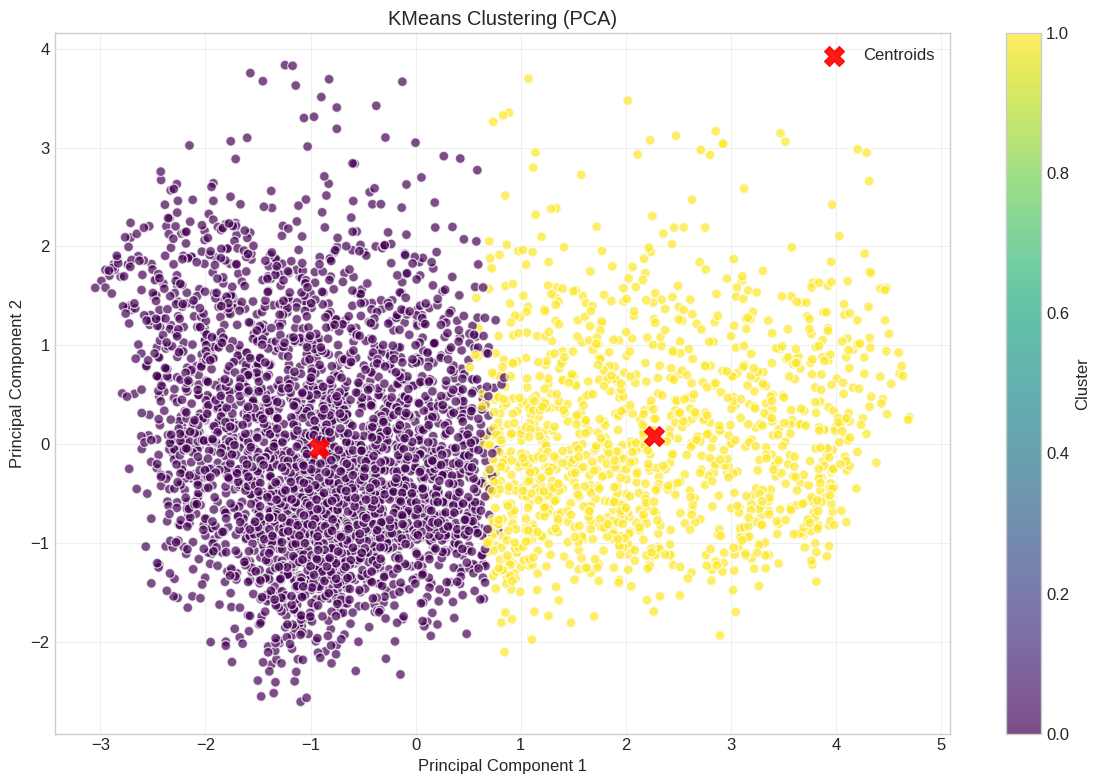

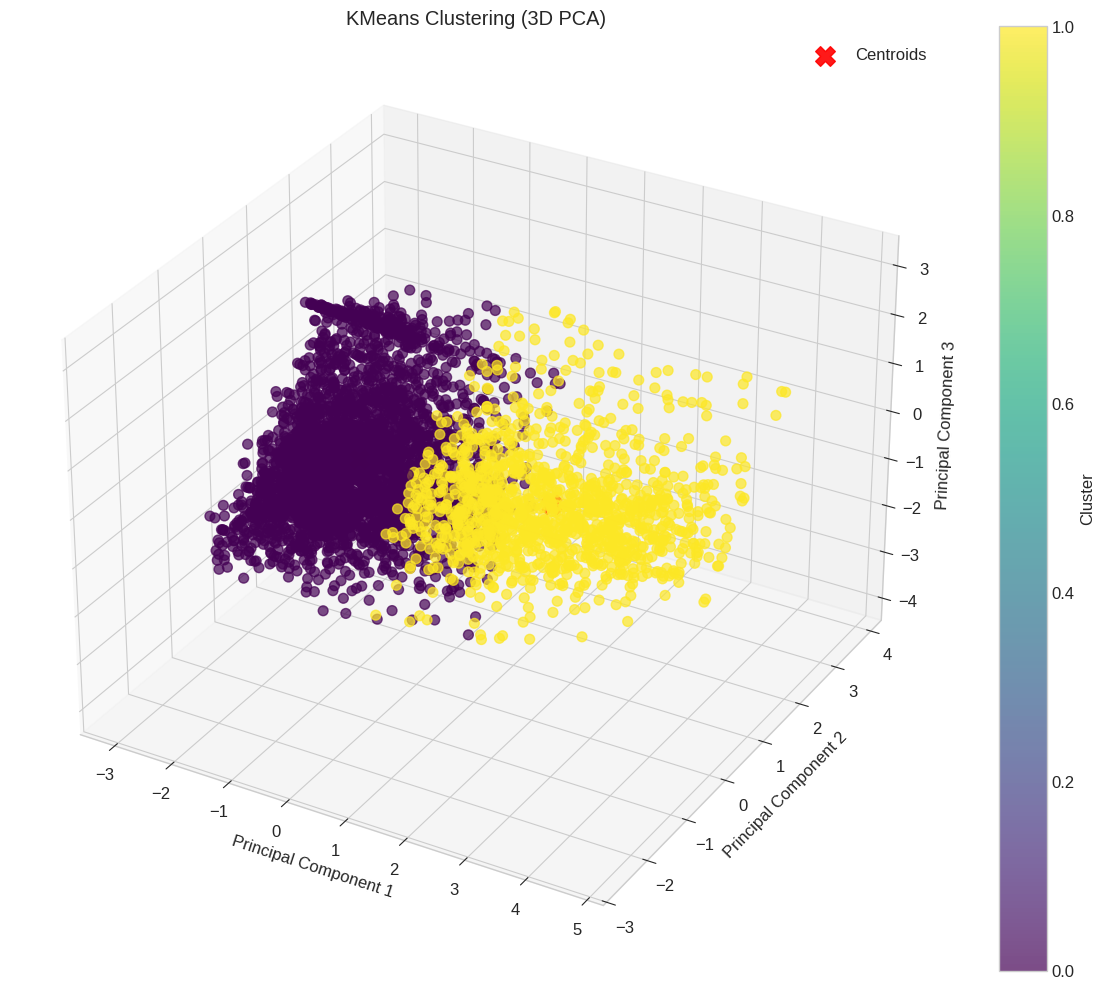


Karakteristik Cluster KMeans:


TransactionCount     Quantity   TotalValue  UnitPrice  \
Cluster_KMeans                                                          
0                       2.018170   335.531798   589.955374   4.837251   
1                       9.802548  3278.577229  5628.157986   3.571664   

                    Recency   StockCode  AvgTransactionValue  
Cluster_KMeans                                                
0               5011.012330   30.279689           328.753243  
1               4924.829618  138.113057           635.772057

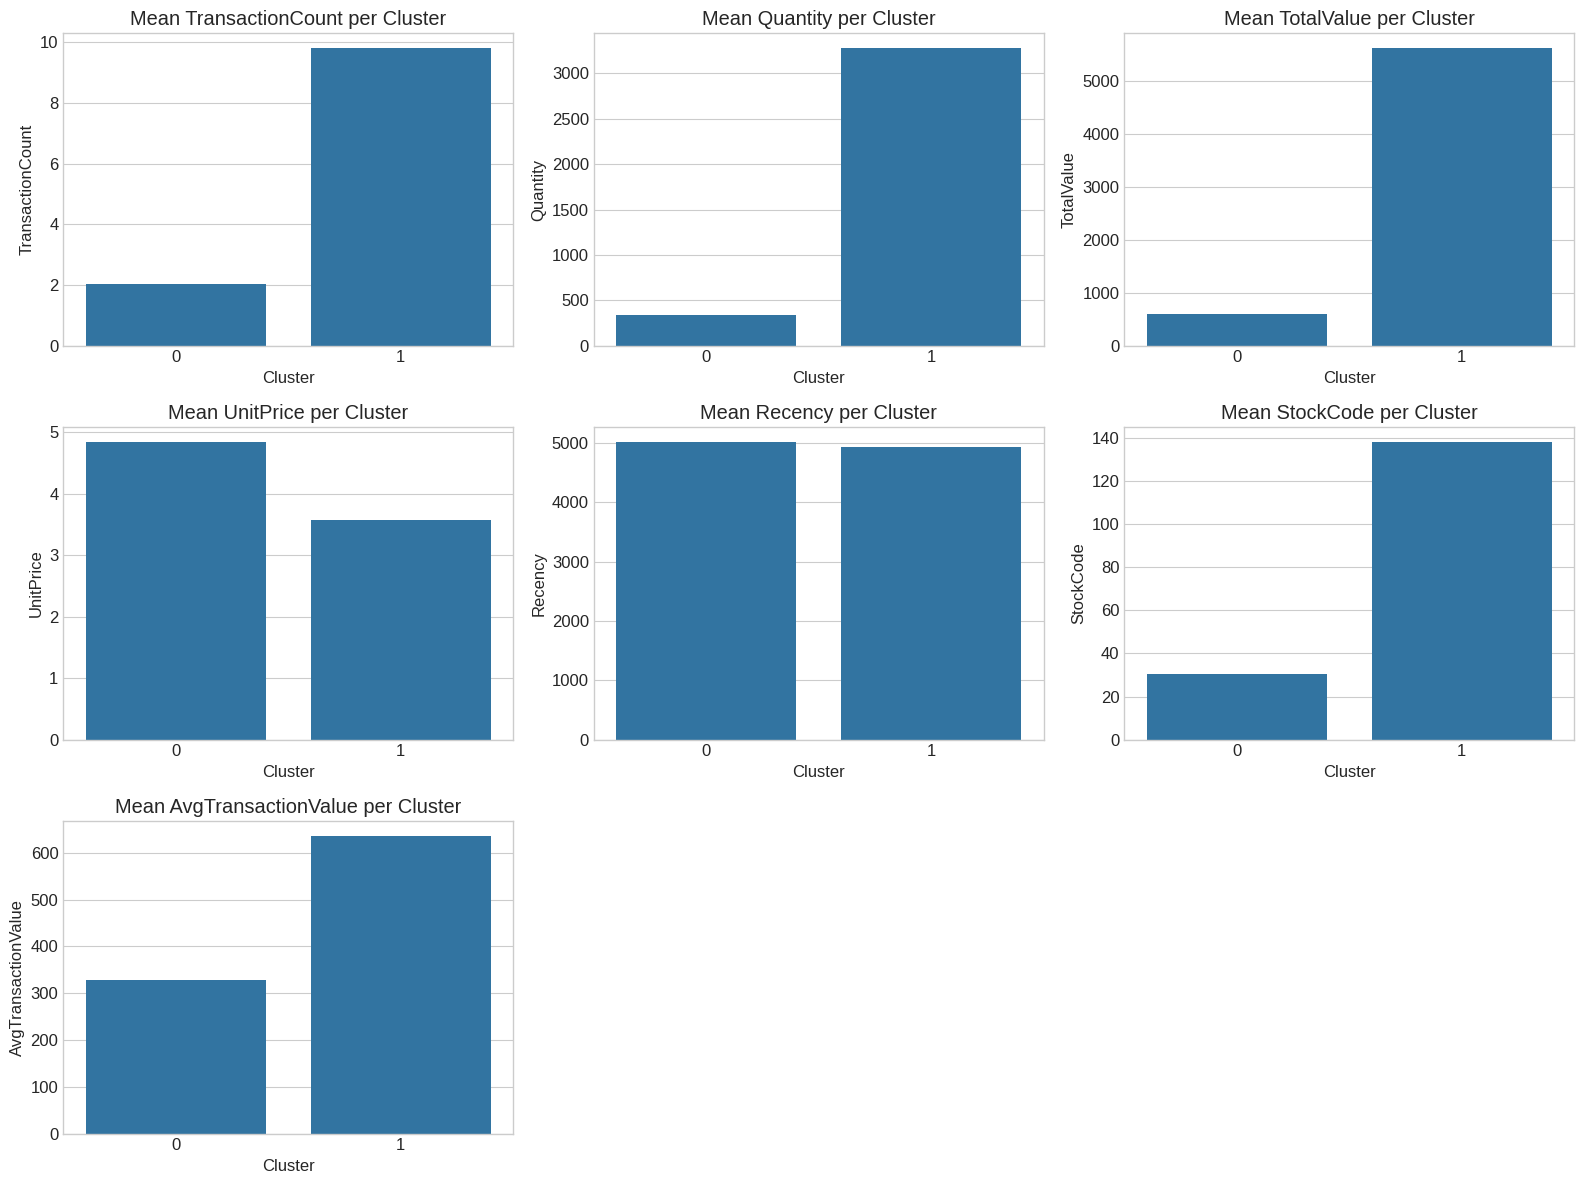

In [16]:
# Menggunakan jumlah cluster optimal dari analisis sebelumnya
optimal_k = optimal_k_silhouette  # Gunakan jumlah cluster berdasarkan silhouette score

# Implementasi K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_df)

# Evaluasi
kmeans_silhouette = silhouette_score(pca_df, kmeans_labels)
kmeans_davies = davies_bouldin_score(pca_df, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(pca_df, kmeans_labels)

print(f"KMeans - Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KMeans - Davies-Bouldin Index: {kmeans_davies:.4f}")
print(f"KMeans - Calinski-Harabasz Score: {kmeans_calinski:.4f}")

# Visualisasi Silhouette Plot untuk KMeans
def plot_silhouette(data, labels, algorithm_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Hitung silhouette scores untuk setiap sampel
    silhouette_vals = silhouette_samples(data, labels)

    # Urutkan silhouette scores berdasarkan cluster
    n_clusters = len(np.unique(labels))
    y_lower, y_upper = 0, 0

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        y_upper += len(cluster_silhouette_vals)

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals,
                height=1.0, edgecolor='none', color=color)

        ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
        y_lower += len(cluster_silhouette_vals)

    # Garis Silhouette Score rata-rata
    avg_silhouette = np.mean(silhouette_vals)
    ax.axvline(avg_silhouette, color="red", linestyle="--")

    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.set_title(f"Silhouette Plot untuk {algorithm_name}\nSilhouette Score: {avg_silhouette:.4f}")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])

    return ax

# Plot silhouette untuk KMeans
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_silhouette(pca_df, kmeans_labels, "KMeans", ax=ax)
plt.tight_layout()
plt.show()

# Visualisasi cluster dengan PCA (2D)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=kmeans_labels, cmap='viridis',
                      alpha=0.7, s=50, edgecolors='w')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red',
            marker='X', s=200, alpha=0.9, label='Centroids')
plt.title('KMeans Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Jika jumlah komponen PCA > 2, buat visualisasi 3D
if pca_df.shape[1] >= 3:
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                         c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               kmeans.cluster_centers_[:, 2], c='red', marker='X', s=200, alpha=0.9, label='Centroids')
    ax.set_title('KMeans Clustering (3D PCA)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.colorbar(scatter, label='Cluster')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Analisis karakteristik cluster
# Tambahkan label cluster ke dataset awal
customer_features_with_cluster = customer_features.copy()
customer_features_with_cluster['Cluster_KMeans'] = kmeans_labels

# Statistik per cluster
cluster_stats = customer_features_with_cluster.groupby('Cluster_KMeans').agg({
    'TransactionCount': 'mean',
    'Quantity': 'mean',
    'TotalValue': 'mean',
    'UnitPrice': 'mean',
    'Recency': 'mean',
    'StockCode': 'mean',
    'AvgTransactionValue': 'mean'
})

print("\nKarakteristik Cluster KMeans:")
display(cluster_stats)

# Visualisasi karakteristik cluster
plt.figure(figsize=(16, 12))
for i, col in enumerate(cluster_stats.columns):
    plt.subplot(3, 3, i+1)
    sns.barplot(x=cluster_stats.index, y=cluster_stats[col])
    plt.title(f'Mean {col} per Cluster')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### 8.2 Agglomerative (Hierarchical) Clustering

Agglomerative - Silhouette Score: 0.3706
Agglomerative - Davies-Bouldin Index: 1.0062
Agglomerative - Calinski-Harabasz Score: 2225.3643


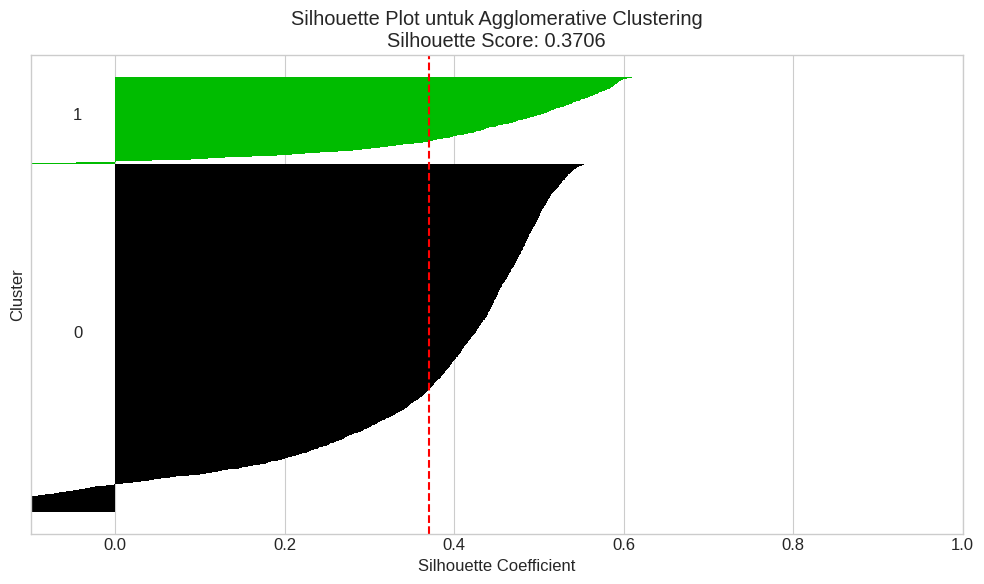

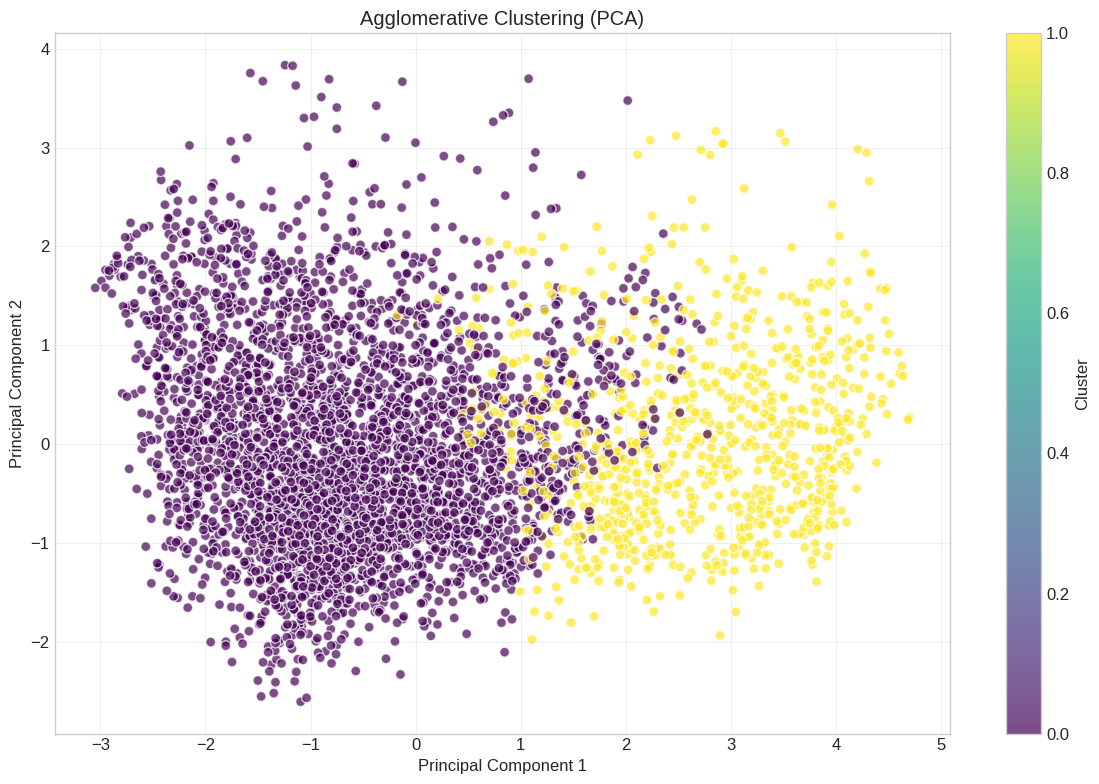

In [17]:
# Implementasi Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(pca_df)

# Evaluasi
agg_silhouette = silhouette_score(pca_df, agg_labels)
agg_davies = davies_bouldin_score(pca_df, agg_labels)
agg_calinski = calinski_harabasz_score(pca_df, agg_labels)

print(f"Agglomerative - Silhouette Score: {agg_silhouette:.4f}")
print(f"Agglomerative - Davies-Bouldin Index: {agg_davies:.4f}")
print(f"Agglomerative - Calinski-Harabasz Score: {agg_calinski:.4f}")

# Visualisasi Silhouette Plot untuk Agglomerative
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_silhouette(pca_df, agg_labels, "Agglomerative Clustering", ax=ax)
plt.tight_layout()
plt.show()

# Visualisasi cluster dengan PCA (2D)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=agg_labels, cmap='viridis',
                      alpha=0.7, s=50, edgecolors='w')
plt.title('Agglomerative Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.3 DBSCAN Clustering

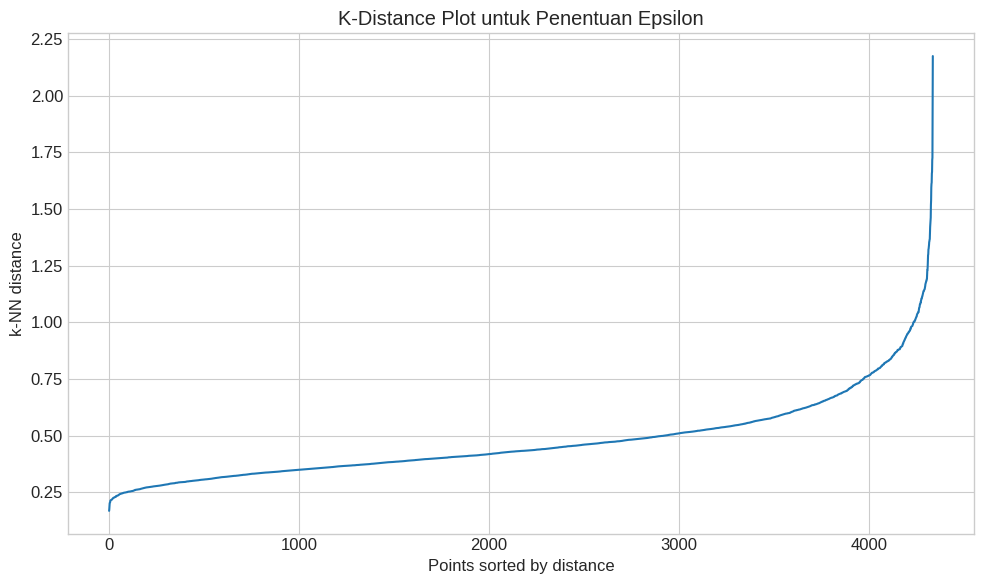

DBSCAN - Jumlah Cluster: 3
DBSCAN - Jumlah Noise Points: 42
DBSCAN - Persentase Noise Points: 0.97%
DBSCAN - Silhouette Score: 0.2171
DBSCAN - Davies-Bouldin Index: 0.6688
DBSCAN - Calinski-Harabasz Score: 36.9266


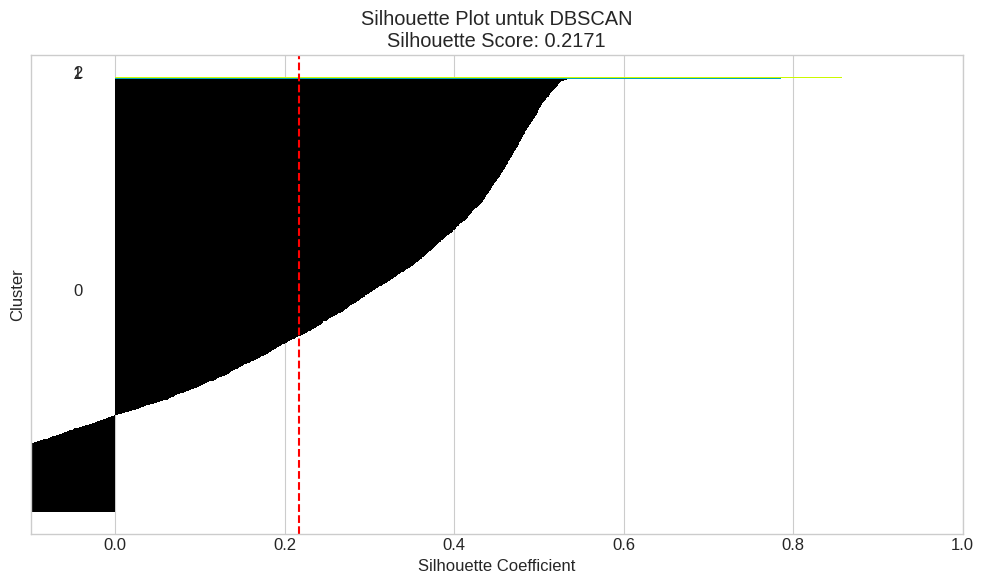

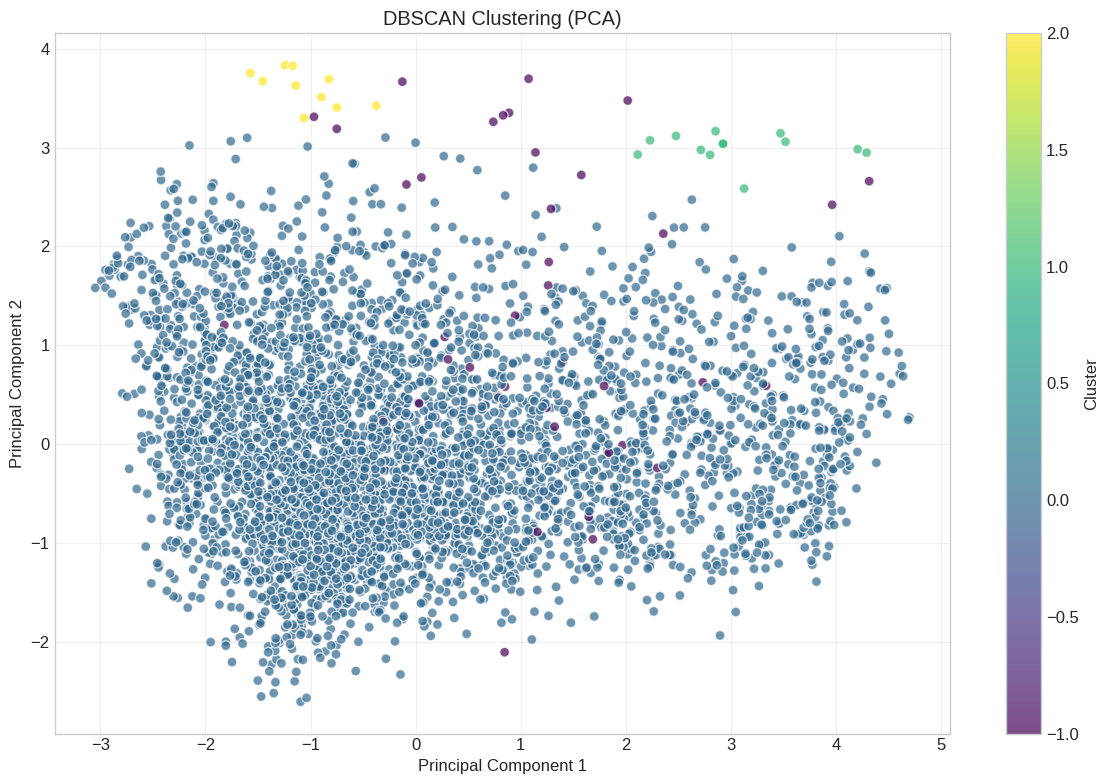


Karakteristik Cluster DBSCAN:


TransactionCount     Quantity    TotalValue  UnitPrice  \
Cluster_DBSCAN                                                           
-1                      6.880952  4583.000000   7030.092143  26.983235   
 0                      4.220922  1132.658554   1939.157633   4.206988   
 1                     15.000000  8866.153846  22376.200000  16.785176   
 2                      1.200000   440.600000   1503.386000   6.645545   

                    Recency   StockCode  AvgTransactionValue  
Cluster_DBSCAN                                                
-1              5081.833333   84.809524          3159.526111  
 0              4984.847414   60.893517           384.664893  
 1              4923.153846  206.923077          1689.655036  
 2              5183.500000   34.200000          1340.850000

In [18]:
# Implementasi DBSCAN
# Cari parameter eps yang optimal dengan k-distance plot
from sklearn.neighbors import NearestNeighbors

# Mencari nilai eps yang optimal
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(pca_df)
distances, indices = neighbors_fit.kneighbors(pca_df)

# Sort distances untuk k-distance plot
distances = np.sort(distances[:, -1])

# Plot k-distance
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Plot untuk Penentuan Epsilon')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-NN distance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Perhatikan "elbow" dalam k-distance plot untuk menentukan eps
# Misalkan kita memilih titik elbow pada eps = 0.8 dengan min_samples = 5
eps_value = 0.8  # Nilai ini harus disesuaikan berdasarkan k-distance plot
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(pca_df)

# Jumlah cluster (tidak termasuk noise points)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN - Jumlah Cluster: {n_clusters}")
print(f"DBSCAN - Jumlah Noise Points: {n_noise}")
print(f"DBSCAN - Persentase Noise Points: {n_noise / len(dbscan_labels) * 100:.2f}%")

# Evaluasi (hanya jika ada lebih dari 1 cluster dan tidak semua titik adalah noise)
if n_clusters > 1 and n_noise < len(dbscan_labels):
    # Filter data untuk evaluasi (hapus noise points)
    mask = dbscan_labels != -1
    dbscan_silhouette = silhouette_score(pca_df.loc[mask], dbscan_labels[mask])
    dbscan_davies = davies_bouldin_score(pca_df.loc[mask], dbscan_labels[mask])
    dbscan_calinski = calinski_harabasz_score(pca_df.loc[mask], dbscan_labels[mask])

    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"DBSCAN - Davies-Bouldin Index: {dbscan_davies:.4f}")
    print(f"DBSCAN - Calinski-Harabasz Score: {dbscan_calinski:.4f}")

    # Visualisasi Silhouette Plot untuk DBSCAN (tanpa noise points)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    plot_silhouette(pca_df.loc[mask], dbscan_labels[mask], "DBSCAN", ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print("DBSCAN tidak menghasilkan cluster yang cukup untuk evaluasi")

# Visualisasi cluster dengan PCA (2D)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=dbscan_labels, cmap='viridis',
                     alpha=0.7, s=50, edgecolors='w')
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analisis karakteristik cluster DBSCAN
customer_features_with_cluster = customer_features.copy()
customer_features_with_cluster['Cluster_DBSCAN'] = dbscan_labels

# Statistik per cluster
cluster_stats_dbscan = customer_features_with_cluster.groupby('Cluster_DBSCAN').agg({
    'TransactionCount': 'mean',
    'Quantity': 'mean',
    'TotalValue': 'mean',
    'UnitPrice': 'mean',
    'Recency': 'mean',
    'StockCode': 'mean',
    'AvgTransactionValue': 'mean'
})

print("\nKarakteristik Cluster DBSCAN:")
display(cluster_stats_dbscan)


### 8.4 Gaussian Mixture Model

GMM - Silhouette Score: 0.2154
GMM - Davies-Bouldin Index: 1.5851
GMM - Calinski-Harabasz Score: 1439.8851


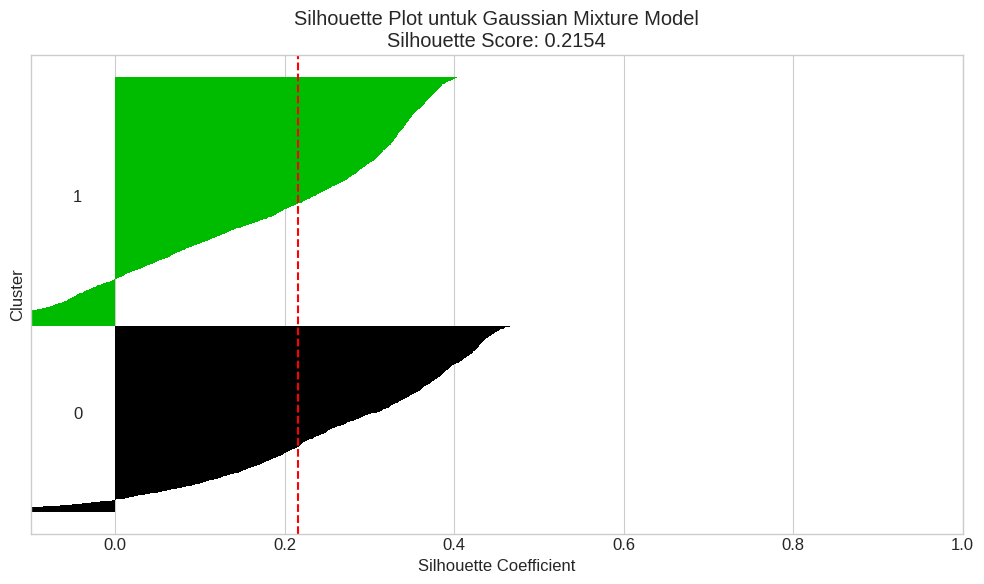

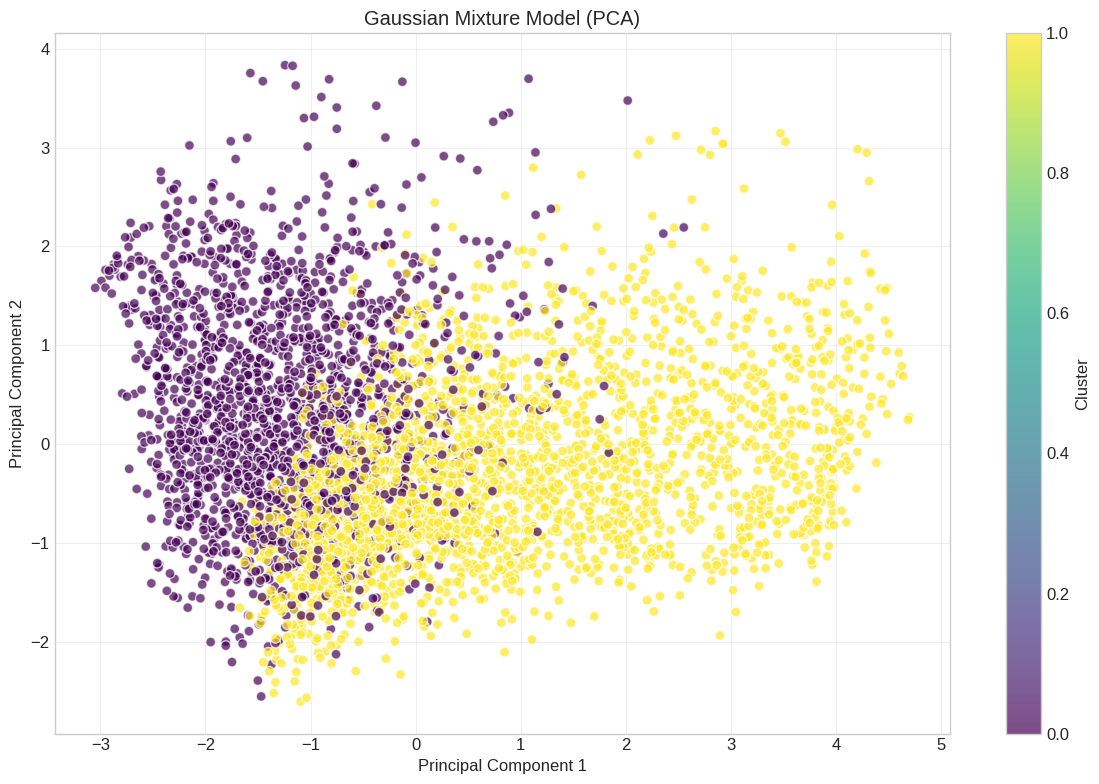


Karakteristik Cluster GMM:


TransactionCount     Quantity   TotalValue  UnitPrice  \
Cluster_GMM                                                          
0                    1.817152   343.976807   628.429095   6.489834   
1                    6.104267  1817.338567  3108.736454   2.963875   

                 Recency  StockCode  AvgTransactionValue  
Cluster_GMM                                               
0            5071.727077  26.188781           365.610043  
1            4922.119163  87.857488           456.483969

In [19]:
# Implementasi Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
gmm_labels = gmm.fit_predict(pca_df)

# Evaluasi
gmm_silhouette = silhouette_score(pca_df, gmm_labels)
gmm_davies = davies_bouldin_score(pca_df, gmm_labels)
gmm_calinski = calinski_harabasz_score(pca_df, gmm_labels)

print(f"GMM - Silhouette Score: {gmm_silhouette:.4f}")
print(f"GMM - Davies-Bouldin Index: {gmm_davies:.4f}")
print(f"GMM - Calinski-Harabasz Score: {gmm_calinski:.4f}")

# Visualisasi Silhouette Plot untuk GMM
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_silhouette(pca_df, gmm_labels, "Gaussian Mixture Model", ax=ax)
plt.tight_layout()
plt.show()

# Visualisasi cluster dengan PCA (2D)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=gmm_labels, cmap='viridis',
                     alpha=0.7, s=50, edgecolors='w')
plt.title('Gaussian Mixture Model (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analisis karakteristik cluster GMM
customer_features_with_cluster = customer_features.copy()
customer_features_with_cluster['Cluster_GMM'] = gmm_labels

# Statistik per cluster
cluster_stats_gmm = customer_features_with_cluster.groupby('Cluster_GMM').agg({
    'TransactionCount': 'mean',
    'Quantity': 'mean',
    'TotalValue': 'mean',
    'UnitPrice': 'mean',
    'Recency': 'mean',
    'StockCode': 'mean',
    'AvgTransactionValue': 'mean'
})

print("\nKarakteristik Cluster GMM:")
display(cluster_stats_gmm)


### 8.5 Spectral Clustering

Spectral - Silhouette Score: 0.3825
Spectral - Davies-Bouldin Index: 1.0220
Spectral - Calinski-Harabasz Score: 2580.1114


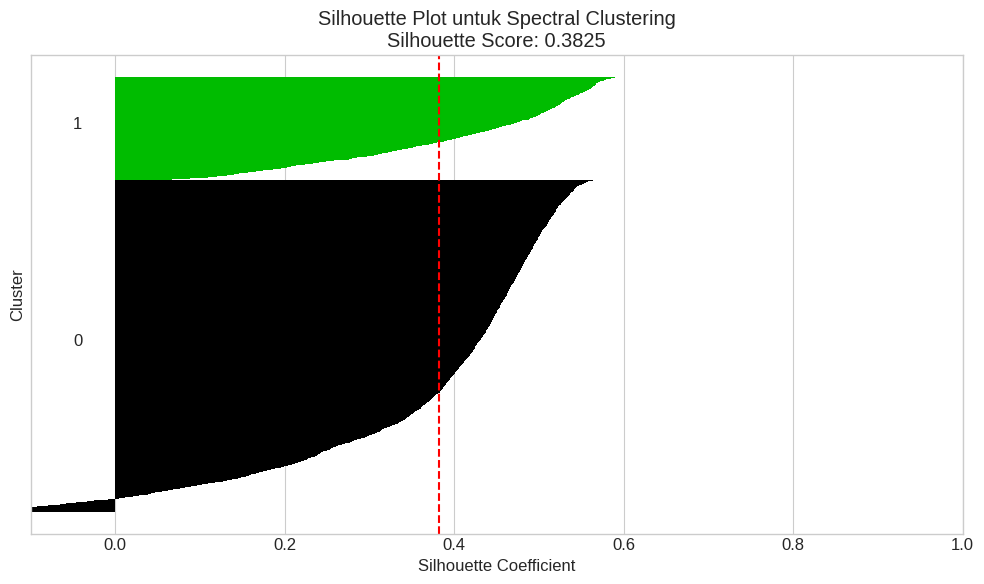

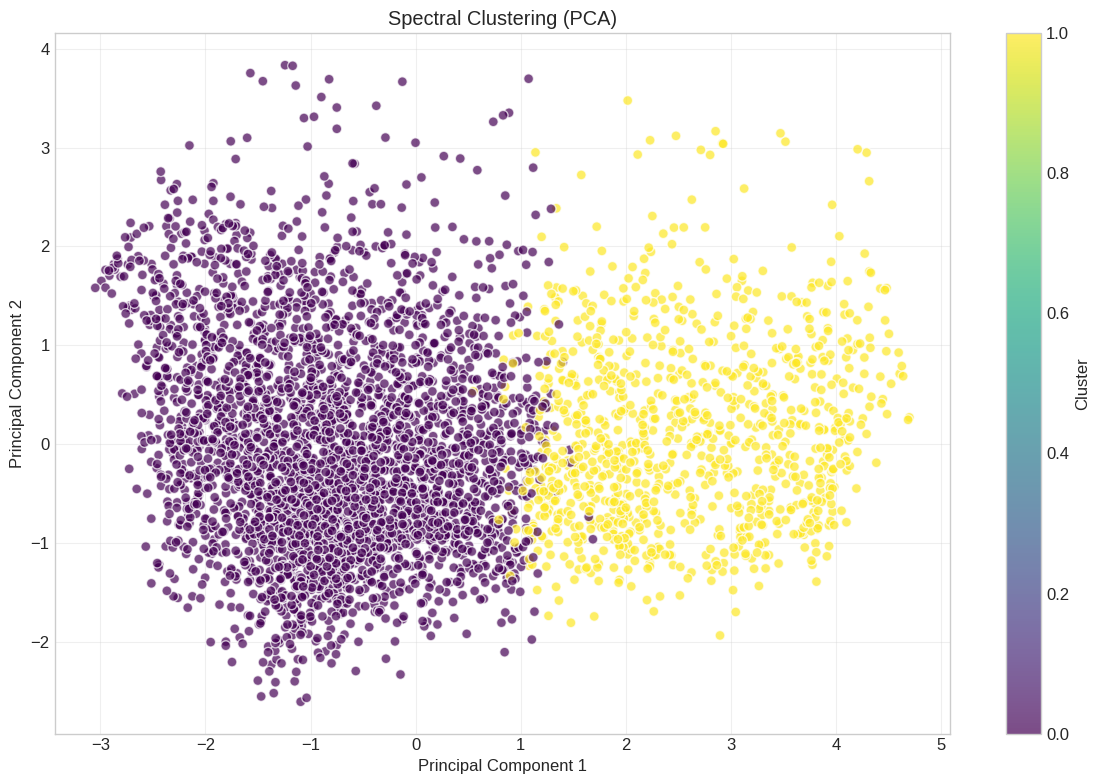


Karakteristik Cluster Spectral:


TransactionCount     Quantity   TotalValue  UnitPrice  \
Cluster_Spectral                                                          
0                         2.187481   397.641367   683.724374   4.844556   
1                        10.958293  3721.631426  6426.898535   3.272037   

                      Recency   StockCode  AvgTransactionValue  
Cluster_Spectral                                                
0                 5007.012096   33.618990           344.691431  
1                 4918.852570  150.935015           651.651442

In [20]:
# Implementasi Spectral Clustering
spectral = SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(pca_df)

# Evaluasi
spectral_silhouette = silhouette_score(pca_df, spectral_labels)
spectral_davies = davies_bouldin_score(pca_df, spectral_labels)
spectral_calinski = calinski_harabasz_score(pca_df, spectral_labels)

print(f"Spectral - Silhouette Score: {spectral_silhouette:.4f}")
print(f"Spectral - Davies-Bouldin Index: {spectral_davies:.4f}")
print(f"Spectral - Calinski-Harabasz Score: {spectral_calinski:.4f}")

# Visualisasi Silhouette Plot untuk Spectral
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_silhouette(pca_df, spectral_labels, "Spectral Clustering", ax=ax)
plt.tight_layout()
plt.show()

# Visualisasi cluster dengan PCA (2D)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=spectral_labels, cmap='viridis',
                     alpha=0.7, s=50, edgecolors='w')
plt.title('Spectral Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analisis karakteristik cluster Spectral
customer_features_with_cluster = customer_features.copy()
customer_features_with_cluster['Cluster_Spectral'] = spectral_labels

# Statistik per cluster
cluster_stats_spectral = customer_features_with_cluster.groupby('Cluster_Spectral').agg({
    'TransactionCount': 'mean',
    'Quantity': 'mean',
    'TotalValue': 'mean',
    'UnitPrice': 'mean',
    'Recency': 'mean',
    'StockCode': 'mean',
    'AvgTransactionValue': 'mean'
})

print("\nKarakteristik Cluster Spectral:")
display(cluster_stats_spectral)

## 9. Perbandingan dan Evaluasi Model

Perbandingan Metrik Evaluasi Model Clustering:


Model  Silhouette Score  Davies-Bouldin Index  \
0         KMeans          0.369058              1.087828   
1  Agglomerative          0.370639              1.006211   
2         DBSCAN          0.217110              0.668848   
3            GMM          0.215354              1.585090   
4       Spectral          0.382516              1.021957   

   Calinski-Harabasz Score  
0              2675.805578  
1              2225.364257  
2                36.926647  
3              1439.885050  
4              2580.111379

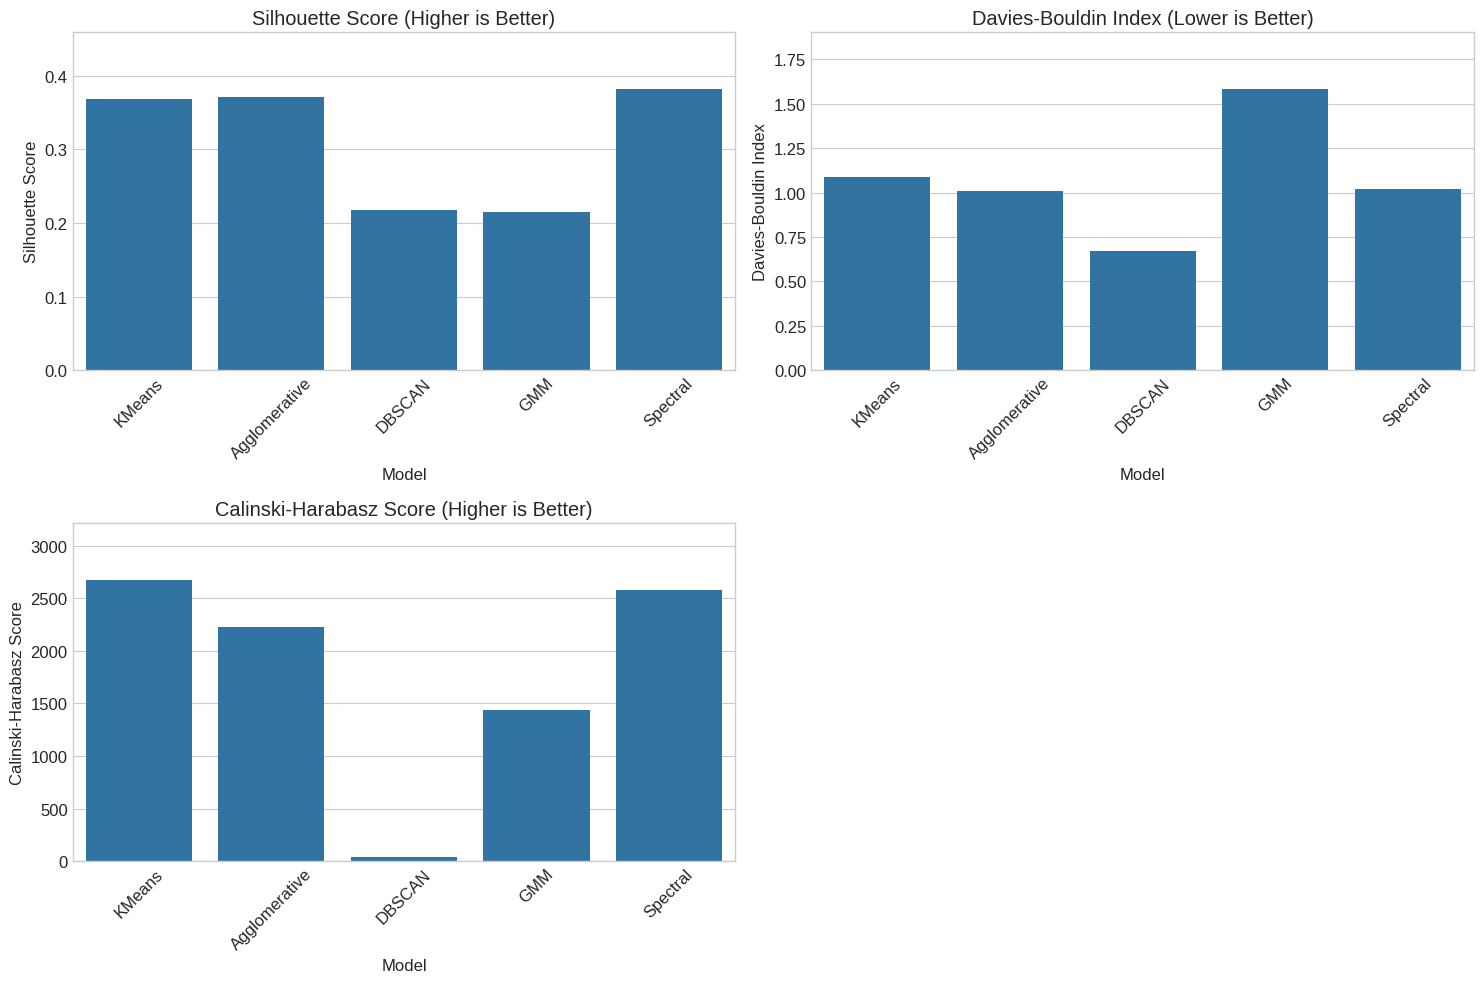

In [21]:
# Buat dataframe untuk membandingkan kinerja model
models = ['KMeans', 'Agglomerative', 'DBSCAN', 'GMM', 'Spectral']
silhouette_scores = [kmeans_silhouette, agg_silhouette]
davies_bouldin_scores = [kmeans_davies, agg_davies]
calinski_harabasz_scores = [kmeans_calinski, agg_calinski]

# Tambahkan skor DBSCAN jika tersedia
if n_clusters > 1 and n_noise < len(dbscan_labels):
    silhouette_scores.append(dbscan_silhouette)
    davies_bouldin_scores.append(dbscan_davies)
    calinski_harabasz_scores.append(dbscan_calinski)
else:
    silhouette_scores.append(np.nan)
    davies_bouldin_scores.append(np.nan)
    calinski_harabasz_scores.append(np.nan)

# Tambahkan skor GMM dan Spectral
silhouette_scores.extend([gmm_silhouette, spectral_silhouette])
davies_bouldin_scores.extend([gmm_davies, spectral_davies])
calinski_harabasz_scores.extend([gmm_calinski, spectral_calinski])

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Model': models,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Index': davies_bouldin_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores
})

print("Perbandingan Metrik Evaluasi Model Clustering:")
display(comparison_df)

# Visualisasi perbandingan
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Silhouette Score', data=comparison_df)
plt.title('Silhouette Score (Higher is Better)')
plt.ylim(0, max(silhouette_scores) * 1.2)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Davies-Bouldin Index', data=comparison_df)
plt.title('Davies-Bouldin Index (Lower is Better)')
plt.ylim(0, max(davies_bouldin_scores) * 1.2)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Calinski-Harabasz Score', data=comparison_df)
plt.title('Calinski-Harabasz Score (Higher is Better)')
plt.ylim(0, max(calinski_harabasz_scores) * 1.2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 10. Analisis Hasil dan Kesimpulan

Model terbaik berdasarkan Silhouette Score:
Spectral dengan nilai 0.3825

Model terbaik berdasarkan Davies-Bouldin Index:
DBSCAN dengan nilai 0.6688

Model terbaik berdasarkan Calinski-Harabasz Score:
KMeans dengan nilai 2675.8056

Karakteristik Cluster dari model terbaik (Spectral):


TransactionCount     Quantity   TotalValue  UnitPrice  \
Best_Cluster                                                          
0                     2.187481   397.641367   683.724374   4.844556   
1                    10.958293  3721.631426  6426.898535   3.272037   

                  Recency   StockCode  AvgTransactionValue  
Best_Cluster                                                
0             5007.012096   33.618990           344.691431  
1             4918.852570  150.935015           651.651442

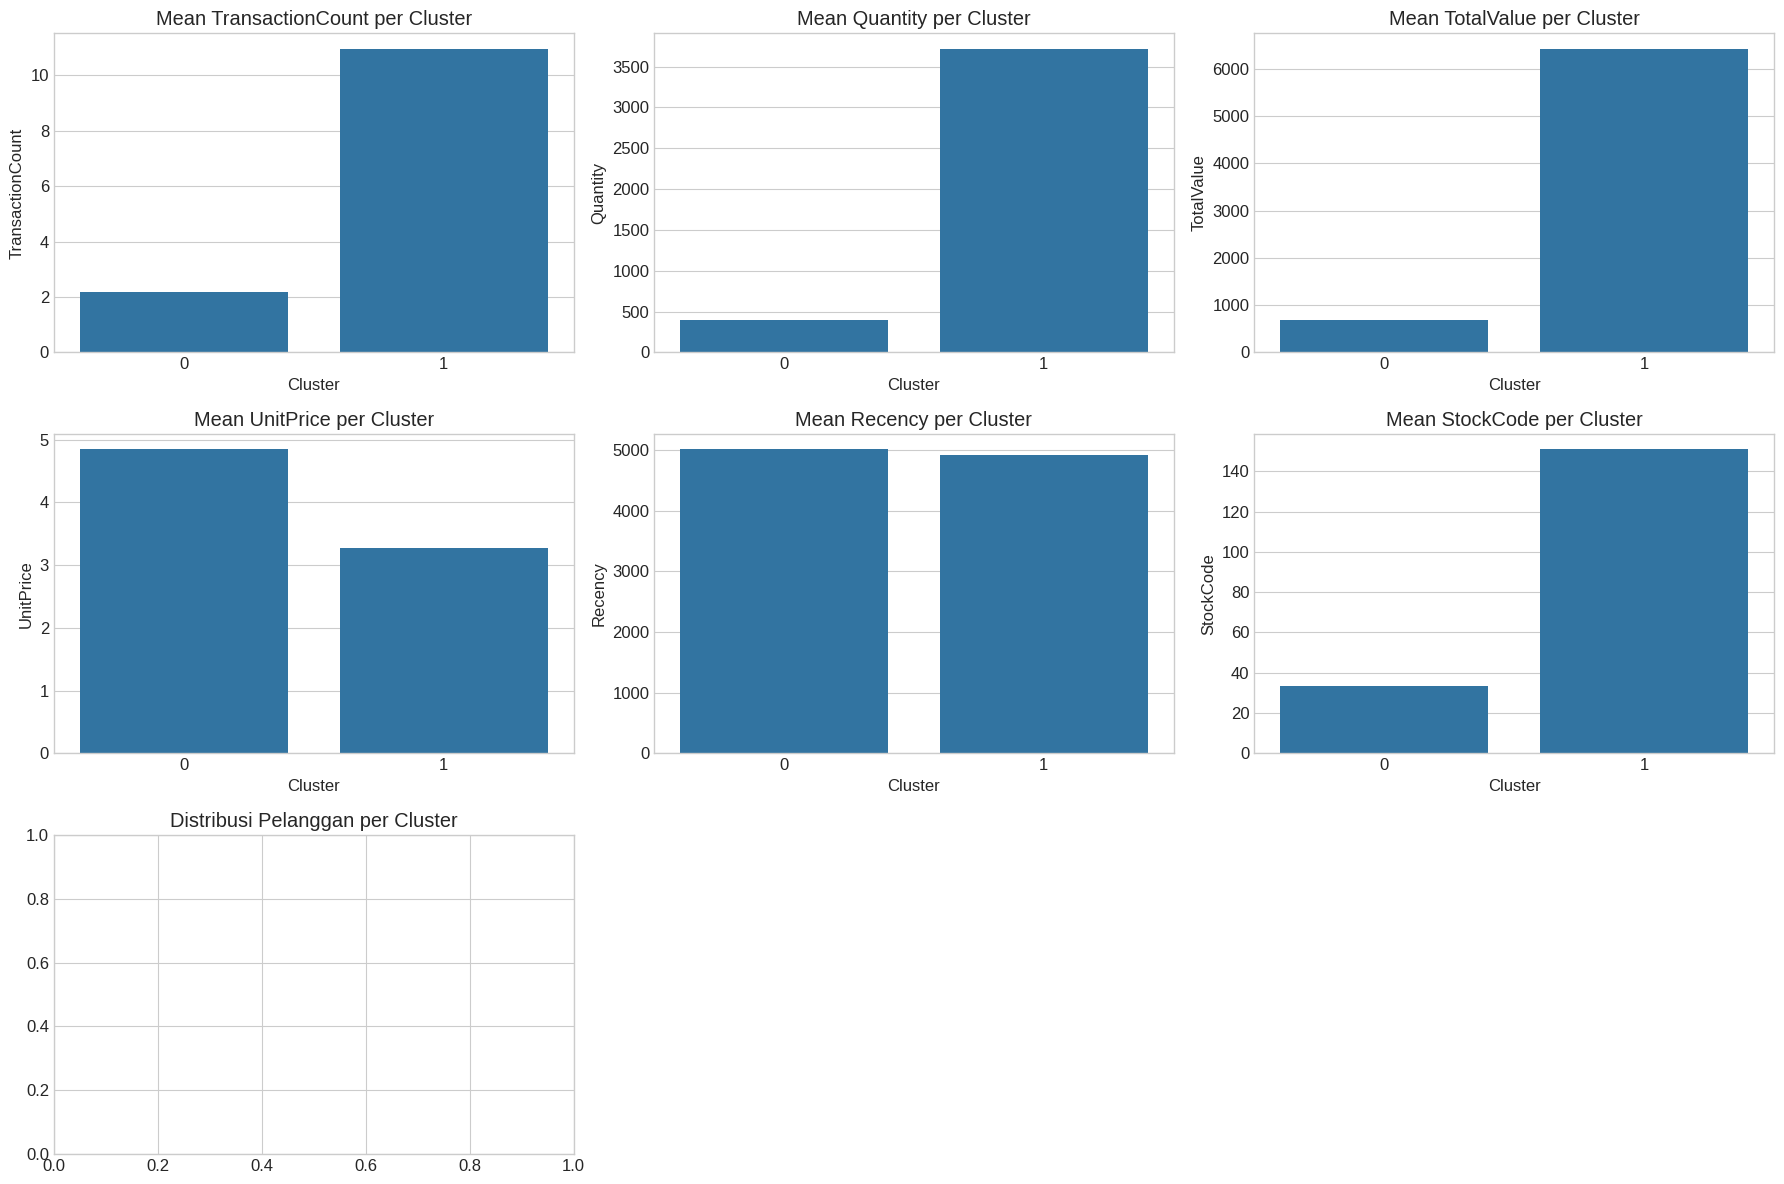


Interpretasi Karakteristik Cluster:

Cluster 0:
Rata-rata Transaksi: 2.19
Rata-rata Total Nilai: 683.72
Rata-rata Recency (hari): 5007.01
Interpretasi: Pelanggan Low-Value dan tidak aktif baru-baru ini

Cluster 1:
Rata-rata Transaksi: 10.96
Rata-rata Total Nilai: 6426.90
Rata-rata Recency (hari): 4918.85
Interpretasi: Pelanggan High-Value dan aktif baru-baru ini


In [32]:
# Temukan model terbaik berdasarkan metrik evaluasi
best_silhouette = comparison_df.loc[comparison_df['Silhouette Score'].idxmax()]
best_davies = comparison_df.loc[comparison_df['Davies-Bouldin Index'].idxmin()]
best_calinski = comparison_df.loc[comparison_df['Calinski-Harabasz Score'].idxmax()]

print("Model terbaik berdasarkan Silhouette Score:")
print(f"{best_silhouette['Model']} dengan nilai {best_silhouette['Silhouette Score']:.4f}")

print("\nModel terbaik berdasarkan Davies-Bouldin Index:")
print(f"{best_davies['Model']} dengan nilai {best_davies['Davies-Bouldin Index']:.4f}")

print("\nModel terbaik berdasarkan Calinski-Harabasz Score:")
print(f"{best_calinski['Model']} dengan nilai {best_calinski['Calinski-Harabasz Score']:.4f}")

# Analisis hasil clustering menggunakan model terbaik
# Misalkan KMeans adalah model terbaik (sesuaikan berdasarkan hasil evaluasi)

# Gunakan best model berdasarkan Silhouette Score
best_model = best_silhouette['Model']
best_labels = None

if best_model == 'KMeans':
    best_labels = kmeans_labels
elif best_model == 'Agglomerative':
    best_labels = agg_labels
elif best_model == 'DBSCAN':
    best_labels = dbscan_labels
elif best_model == 'GMM':
    best_labels = gmm_labels
elif best_model == 'Spectral':
    best_labels = spectral_labels

# Gabungkan label cluster dari model terbaik dengan data pelanggan asli
customer_features['Best_Cluster'] = best_labels

# Karakteristik setiap cluster
best_cluster_stats = customer_features.groupby('Best_Cluster').agg({
    'TransactionCount': 'mean',
    'Quantity': 'mean',
    'TotalValue': 'mean',
    'UnitPrice': 'mean',
    'Recency': 'mean',
    'StockCode': 'mean',
    'AvgTransactionValue': 'mean',
})

print(f"\nKarakteristik Cluster dari model terbaik ({best_model}):")
display(best_cluster_stats)

# Visualisasi karakteristik cluster terbaik
plt.figure(figsize=(18, 12))
for i, col in enumerate(best_cluster_stats.columns[:-1]):  # Exclude CustomerCount
    plt.subplot(3, 3, i+1)
    sns.barplot(x=best_cluster_stats.index, y=best_cluster_stats[col])
    plt.title(f'Mean {col} per Cluster')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)

plt.subplot(3, 3, len(best_cluster_stats.columns[:-1])+1)
plt.title('Distribusi Pelanggan per Cluster')

plt.tight_layout()
plt.show()

# Deskripsi karakteristik setiap cluster dan interpretasi bisnis
print("\nInterpretasi Karakteristik Cluster:")
for cluster in best_cluster_stats.index:
    print(f"\nCluster {cluster}:")
    print(f"Rata-rata Transaksi: {best_cluster_stats.loc[cluster, 'TransactionCount']:.2f}")
    print(f"Rata-rata Total Nilai: {best_cluster_stats.loc[cluster, 'TotalValue']:.2f}")
    print(f"Rata-rata Recency (hari): {best_cluster_stats.loc[cluster, 'Recency']:.2f}")

    # Interpretasi cluster
    if best_cluster_stats.loc[cluster, 'TotalValue'] > best_cluster_stats['TotalValue'].mean():
        if best_cluster_stats.loc[cluster, 'Recency'] < best_cluster_stats['Recency'].mean():
            print("Interpretasi: Pelanggan High-Value dan aktif baru-baru ini")
        else:
            print("Interpretasi: Pelanggan High-Value tetapi tidak aktif baru-baru ini")
    else:
        if best_cluster_stats.loc[cluster, 'Recency'] < best_cluster_stats['Recency'].mean():
            print("Interpretasi: Pelanggan Low-Value tetapi aktif baru-baru ini")
        else:
            print("Interpretasi: Pelanggan Low-Value dan tidak aktif baru-baru ini")

## 11. Kesimpulan dan Rekomendasi

In [33]:
# Kesimpulan metrik evaluasi
print("Kesimpulan Evaluasi Model:")
print(f"1. Model terbaik berdasarkan Silhouette Score: {best_silhouette['Model']}")
print(f"   - Silhouette Score: {best_silhouette['Silhouette Score']:.4f}")
print(f"2. Model terbaik berdasarkan Davies-Bouldin Index: {best_davies['Model']}")
print(f"   - Davies-Bouldin Index: {best_davies['Davies-Bouldin Index']:.4f}")
print(f"3. Model terbaik berdasarkan Calinski-Harabasz Score: {best_calinski['Model']}")
print(f"   - Calinski-Harabasz Score: {best_calinski['Calinski-Harabasz Score']:.4f}")

# Rekomendasi berdasarkan karakteristik cluster
print("\nRekomendasi Strategi Bisnis Berdasarkan Hasil Clustering:")

for cluster in best_cluster_stats.index:
    print(f"\nCluster {cluster}:")

    # High-Value, Recently Active
    if (best_cluster_stats.loc[cluster, 'TotalValue'] > best_cluster_stats['TotalValue'].mean() and
        best_cluster_stats.loc[cluster, 'Recency'] < best_cluster_stats['Recency'].mean()):
        print("- Pelanggan berharga yang aktif")
        print("- Rekomendasi: Program loyalitas khusus, penawaran eksklusif, dan VIP benefits")

    # High-Value, Not Recently Active
    elif (best_cluster_stats.loc[cluster, 'TotalValue'] > best_cluster_stats['TotalValue'].mean() and
          best_cluster_stats.loc[cluster, 'Recency'] >= best_cluster_stats['Recency'].mean()):
        print("- Pelanggan berharga yang berisiko churning")
        print("- Rekomendasi: Program retensi, insentif untuk kembali berbelanja, dan penawaran personalisasi")

    # Low-Value, Recently Active
    elif (best_cluster_stats.loc[cluster, 'TotalValue'] <= best_cluster_stats['TotalValue'].mean() and
          best_cluster_stats.loc[cluster, 'Recency'] < best_cluster_stats['Recency'].mean()):
        print("- Pelanggan dengan potensi pertumbuhan")
        print("- Rekomendasi: Cross-selling, upselling, dan program untuk meningkatkan nilai transaksi")

    # Low-Value, Not Recently Active
    else:
        print("- Pelanggan dengan engagement rendah")
        print("- Rekomendasi: Program reaktivasi dengan penawaran menarik atau pertimbangkan biaya akuisisi customer baru")

# Kesimpulan akhir
print("\nKesimpulan Akhir:")
print(f"Analisis clustering dengan {best_silhouette['Model']} mengidentifikasi {optimal_k} segmen pelanggan yang berbeda.")
print("Strategi pemasaran yang tepat untuk setiap segmen dapat meningkatkan retensi pelanggan dan nilai transaksi.")
print("Monitoring dan evaluasi segmen secara berkala diperlukan untuk memastikan strategi tetap relevan.")

Kesimpulan Evaluasi Model:
1. Model terbaik berdasarkan Silhouette Score: Spectral
   - Silhouette Score: 0.3825
2. Model terbaik berdasarkan Davies-Bouldin Index: DBSCAN
   - Davies-Bouldin Index: 0.6688
3. Model terbaik berdasarkan Calinski-Harabasz Score: KMeans
   - Calinski-Harabasz Score: 2675.8056

Rekomendasi Strategi Bisnis Berdasarkan Hasil Clustering:

Cluster 0:
- Pelanggan dengan engagement rendah
- Rekomendasi: Program reaktivasi dengan penawaran menarik atau pertimbangkan biaya akuisisi customer baru

Cluster 1:
- Pelanggan berharga yang aktif
- Rekomendasi: Program loyalitas khusus, penawaran eksklusif, dan VIP benefits

Kesimpulan Akhir:
Analisis clustering dengan Spectral mengidentifikasi 2 segmen pelanggan yang berbeda.
Strategi pemasaran yang tepat untuk setiap segmen dapat meningkatkan retensi pelanggan dan nilai transaksi.
Monitoring dan evaluasi segmen secara berkala diperlukan untuk memastikan strategi tetap relevan.


## 12. Ringkasan Pipeline End-to-End

Dalam analisis ini, kita telah melakukan pipeline end-to-end untuk clustering model machine learning:

1. **Pengumpulan dan Pembersihan Data**:
   - Membaca dataset transaksi retail
   - Menangani nilai yang hilang dan duplikat
   - Konversi tipe data dan membuat fitur baru dari tanggal

2. **Feature Selection dan Engineering**:
   - Eliminasi fitur konstan dan quasi-konstan
   - Analisis korelasi untuk menghilangkan redundansi
   - Deteksi dan penanganan outlier dengan metode capping
   - Standardisasi data dengan StandardScaler
   - Reduksi dimensi dengan PCA

3. **Implementasi Model Clustering**:
   - KMeans
   - AgglomerativeClustering
   - DBSCAN
   - GaussianMixture
   - SpectralClustering

4. **Evaluasi Model**:
   - Silhouette Score
   - Davies-Bouldin Index
   - Calinski-Harabasz Score
   - Visualisasi dengan Silhouette Plot, Dendrogram, dan Cluster Scatter Plot

5. **Analisis Hasil dan Interpretasi Bisnis**:
   - Karakteristik setiap cluster
   - Rekomendasi strategi berdasarkan segmentasi

Hasil analisis ini memberikan wawasan berharga tentang segmentasi pelanggan yang dapat digunakan untuk mengoptimalkan strategi pemasaran dan meningkatkan kinerja bisnis.
